In [1]:
import time
import os
import numpy as np
import pandas as pd
import pickle
import h5py
import re
from mmsdk import mmdatasdk
from mmsdk.mmdatasdk.computational_sequence.computational_sequence import computational_sequence
from mmsdk.mmdatasdk.dataset.standard_datasets.CMU_MOSEI import cmu_mosei_std_folds

import torch
from torch.optim import Adam
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook
from collections import defaultdict


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import xgboost

In [3]:
with open('data/aligned_mosei.pkl', 'rb') as f:
    dataset = pickle.load(f)

print(type(dataset))
print(dataset.keys() if hasattr(dataset, 'keys') else dataset)

<class 'mmsdk.mmdatasdk.dataset.dataset.mmdataset'>
dict_keys(['CMU_MOSEI_TimestampedWordVectors', 'CMU_MOSEI_VisualFacet42', 'CMU_MOSEI_COVAREP', 'CMU_MOSEI_Labels'])


In [4]:
visual_field = 'CMU_MOSEI_VisualFacet42'
acoustic_field = 'CMU_MOSEI_COVAREP'
text_field = 'CMU_MOSEI_TimestampedWordVectors'
label_field = 'CMU_MOSEI_Labels'

features = [
    text_field,
    visual_field,
    acoustic_field
]

len(dataset[text_field].keys())
len(dataset[acoustic_field].keys())

23248

In [5]:
dataset[label_field]['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[1.       , 0.6666667, 0.       , 0.       , 0.       , 0.       ,
         0.       ]], dtype=float32)}

In [6]:
sentiment_labels = {}
emotion_labels = {}

for key in dataset[label_field].keys():
    features = dataset[label_field][key]['features']
    sentiment_labels[key] = dataset[label_field][key].copy()
    emotion_labels[key] = dataset[label_field][key].copy()
    sentiment_labels[key]['features'] = features[0][0]
    sentiment_labels[key]['features'] = np.expand_dims(np.expand_dims(sentiment_labels[key]['features'], axis=0), axis=0)
    emotion_labels[key]['features'] = features[0][1:]
    emotion_labels[key]['features'] = np.expand_dims(emotion_labels[key]['features'], axis=0)

In [7]:
sentiment_labels['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[1.]], dtype=float32)}

In [8]:
emotion_labels['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[0.6666667, 0.       , 0.       , 0.       , 0.       , 0.       ]],
       dtype=float32)}

In [9]:
# Split the dataset.
# obtain the train/valid/test splits - these splits are based on video IDs
train_split = cmu_mosei_std_folds.standard_train_fold
valid_split = cmu_mosei_std_folds.standard_valid_fold
test_split = cmu_mosei_std_folds.standard_test_fold

# inspect the splits: they only contain video IDs
# print(test_split)

In [10]:
# a sentinel epsilon for safe division, without it we will replace illegal values with a constant
EPS = 0

# place holders for the final train/valid/test dataset
train = []
valid = []
test = []

# define a regular expression to extract the video ID out of the keys
pattern = re.compile('(.*)\[.*\]')
num_drop = 0 # a counter to count how many data points went into some processing issues

valid_keys = set(dataset[label_field].keys()) & set(dataset[text_field].keys()) & set(dataset[visual_field].keys()) & set(dataset[acoustic_field].keys())

<>:10: SyntaxWarning: invalid escape sequence '\['
<>:10: SyntaxWarning: invalid escape sequence '\['
C:\Users\suxin\AppData\Local\Temp\ipykernel_40100\719142960.py:10: SyntaxWarning: invalid escape sequence '\['
  pattern = re.compile('(.*)\[.*\]')


In [11]:
for segment in dataset[label_field].keys():

    if segment not in valid_keys:
        continue

    # get the video ID and the features out of the aligned dataset
    vid = re.search(pattern, segment).group(1)
    label = sentiment_labels[segment]['features']
    words = dataset[text_field][segment]['features']
    visual = dataset[visual_field][segment]['features']
    acoustic = dataset[acoustic_field][segment]['features']
    emotions = emotion_labels[segment]['features']

    # if the sequences are not same length after alignment, there must be some problem with some modalities
    # we should drop it or inspect the data again
    if not words.shape[0] == visual.shape[0] == acoustic.shape[0]:
        print(f"Encountered datapoint {vid} with text shape {words.shape}, visual shape {visual.shape}, acoustic shape {acoustic.shape}")
        num_drop += 1

    # remove nan values
    label = np.nan_to_num(label)
    words = np.nan_to_num(words)
    visual = np.nan_to_num(visual)
    acoustic = np.nan_to_num(acoustic)
    emotions = np.nan_to_num(emotions)

    # z-normalization per instance and remove nan/infs
    visual = np.nan_to_num((visual - visual.mean(0, keepdims=True)) / (EPS + np.std(visual, axis=0, keepdims=True)))
    acoustic = np.nan_to_num((acoustic - acoustic.mean(0, keepdims=True)) / (EPS + np.std(acoustic, axis=0, keepdims=True)))

    if vid in train_split:
        train.append(((words, visual, acoustic), label, emotions, segment))
    elif vid in valid_split:
        valid.append(((words, visual, acoustic), label, emotions,segment))
    elif vid in test_split:
        test.append(((words, visual, acoustic), label, emotions,segment))
    # else:
    #     print(f"Found video that doesn't belong to any splits: {vid}")

print(f"Total number of {num_drop} datapoints have been dropped.")

Encountered datapoint -ZgjBOA1Yhw with text shape (38, 300), visual shape (37, 35), acoustic shape (38, 74)


C:\Users\suxin\AppData\Local\Temp\ipykernel_40100\2181468976.py:29: RuntimeWarning: invalid value encountered in divide
  acoustic = np.nan_to_num((acoustic - acoustic.mean(0, keepdims=True)) / (EPS + np.std(acoustic, axis=0, keepdims=True)))
C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\suxin\AppData\Local\Temp\ipykernel_40100\2181468976.py:28: RuntimeWarning: invalid value encountered in divide
  visual = np.nan_to_num((visual - visual.mean(0, keepdims=True)) / (EPS + np.std(visual, axis=0, keepdims=True)))
C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = u

Encountered datapoint 0hCOCt6fWas with text shape (18, 300), visual shape (17, 35), acoustic shape (18, 74)
Encountered datapoint 1zXAYdPdzy8 with text shape (36, 300), visual shape (35, 35), acoustic shape (36, 74)
Encountered datapoint 69824 with text shape (7, 300), visual shape (6, 35), acoustic shape (7, 74)
Encountered datapoint 8f_lBxZgDb0 with text shape (55, 300), visual shape (54, 35), acoustic shape (55, 74)
Encountered datapoint 92221 with text shape (8, 300), visual shape (7, 35), acoustic shape (8, 74)
Encountered datapoint Iemw8vqt-54 with text shape (19, 300), visual shape (18, 35), acoustic shape (19, 74)
Encountered datapoint JGEEA_JVriE with text shape (115, 300), visual shape (79, 35), acoustic shape (115, 74)
Encountered datapoint JXYot3NDQn0 with text shape (43, 300), visual shape (42, 35), acoustic shape (43, 74)
Encountered datapoint Q5uYByRyswI with text shape (76, 300), visual shape (75, 35), acoustic shape (76, 74)
Encountered datapoint aa0J1AXSseY with text 

In [12]:
# let's see the size of each set and shape of data
print(len(train))
print(len(valid))
print(len(test))

print(train[0][0][0].shape)
print(train[0][0][1].shape)
print(train[0][0][2].shape)
print(train[0][1].shape)

print(train[0][0])
print(train[0][1])
print(train[0][2])

16322
1871
4659
(55, 300)
(55, 35)
(55, 74)
(1, 1)
(array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.33578  ,  0.30902  ,  0.12098  , ...,  0.26556  , -0.15987  ,
        -0.033962 ],
       [-0.084961 ,  0.502    ,  0.0023823, ..., -0.21511  , -0.26304  ,
        -0.0060173],
       ...,
       [-0.028387 ,  0.050244 , -0.076597 , ..., -0.16328  , -0.043587 ,
         0.036996 ],
       [-0.70567  ,  0.48464  , -0.26169  , ..., -0.1398   ,  0.42836  ,
         0.017546 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], shape=(55, 300)), array([[-5.0590074e-01, -5.4795736e-01,  4.1057914e-01, ...,
        -3.3446416e-01, -8.5609153e-02,  4.7459543e-01],
       [ 9.0985417e-02, -1.4090555e+00,  3.1989036e+00, ...,
        -6.6909468e-01, -2.3426114e-01, -2.6542366e-01],
       [-6.6859627e-01,  3.3285603e-01,  1.8611795e-01, ...,
         2.0832238e-01,  1.0378593e+00, -9.4906610e-01],

In [28]:
def multi_collate(batch):
    '''
    Collate functions assume batch = [Dataset[i] for i in index_set]
    '''
    # for later use we sort the batch in descending order of length
    batch = sorted(batch, key=lambda x: x[0][0].shape[0], reverse=True)
    
    # get the data out of the batch
    labels = torch.cat([torch.from_numpy(sample[1]) for sample in batch], dim=0)
    sentences = pad_sequence([torch.FloatTensor(sample[0][0]) for sample in batch])
    visual = pad_sequence([torch.FloatTensor(sample[0][1]) for sample in batch])
    acoustic = pad_sequence([torch.FloatTensor(sample[0][2]) for sample in batch])
    
    # lengths are useful later in using RNNs
    lengths = torch.LongTensor([sample[0][0].shape[0] for sample in batch])
    return sentences, visual, acoustic, labels, lengths

# construct dataloaders, valid and test could use around ~X3 times batch size since no_grad is used during eval
batch_sz = 32
train_loader = DataLoader(train, shuffle=True, batch_size=batch_sz, collate_fn=multi_collate)
valid_loader = DataLoader(valid, shuffle=False, batch_size=batch_sz*3, collate_fn=multi_collate)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_sz*3, collate_fn=multi_collate)

# create a temporary dataloader just to see how the batch looks like
temp_loader = iter(DataLoader(test, shuffle=True, batch_size=8, collate_fn=multi_collate))
batch = next(temp_loader)

print(batch[0].shape) # word vectors
print(batch[1].shape) # visual features
print(batch[2].shape) # acoustic features
print(batch[3]) # labels
print(batch[4]) # lengths
print(batch[4].size(0)) # batch size

torch.Size([49, 8, 300])
torch.Size([49, 8, 35])
torch.Size([49, 8, 74])
tensor([[ 0.6667],
        [ 1.3333],
        [ 0.3333],
        [ 0.6667],
        [-2.0000],
        [ 1.6667],
        [-0.3333],
        [ 1.3333]])
tensor([49, 43, 30, 27, 24, 24, 14, 13])
8


In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_uniform, xavier_normal, orthogonal

In [15]:
class DNN(nn.Module):
    '''
    The subnetwork that is used in TFN in the pre-fusion stage
    '''

    def __init__(self, in_size, hidden_size, dropout):
        '''
        Args:
            in_size: input dimension
            hidden_size: hidden layer dimension
            dropout: dropout probability
        Output:
            (return value in forward) a tensor of shape (batch_size, hidden_size)
        '''
        super(DNN, self).__init__()
        self.norm = nn.BatchNorm1d(in_size)
        self.drop = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(in_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        '''
        Args:
            x: tensor of shape (batch_size, in_size)
        '''
        normed = self.norm(x)
        dropped = self.drop(normed)
        y_1 = F.relu(self.linear_1(dropped))
        y_2 = F.relu(self.linear_2(y_1))
        y_3 = F.relu(self.linear_3(y_2))

        return y_3

In [ ]:
class CNN1DSubnet(nn.Module):
    """
    A 1D-CNN sub-network for processing a single modality.
    It applies convolutions over the sequence dimension and uses
    global average pooling to produce a fixed-size feature vector.
    
    Input shape: (batch_size, seq_len, in_size)
    Output shape: (batch_size, out_size)
    """
    def __init__(self, in_size, hidden_size, out_size, kernel_size=3, dropout=0.25, num_layers=2):
        super(CNN1DSubnet, self).__init__()
        
        if kernel_size <= 0:
            raise ValueError("kernel_size must be positive")
        if kernel_size % 2 == 0:
            raise ValueError("kernel_size should be odd for symmetric padding")
        if dropout < 0 or dropout > 1:
            raise ValueError("dropout must be between 0 and 1")
        if in_size <= 0 or hidden_size <= 0 or out_size <= 0:
            raise ValueError("All size parameters must be positive")
        
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.num_layers = num_layers
        
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        self.conv_layers.append(nn.Conv1d(in_size, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2))
        self.bn_layers.append(nn.BatchNorm1d(hidden_size))
        self.dropout_layers.append(nn.Dropout(dropout))
        
        for _ in range(num_layers - 1):
            self.conv_layers.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2))
            self.bn_layers.append(nn.BatchNorm1d(hidden_size))
            self.dropout_layers.append(nn.Dropout(dropout))
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_size, out_size)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        Forward pass of the CNN1D subnet.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, in_size)
        
        Returns:
            Output tensor of shape (batch_size, out_size)
        """
        if x.dim() != 3:
            raise ValueError(f"Expected 3D input tensor, got {x.dim()}D")
        
        batch_size, seq_len, feature_dim = x.shape
        
        if feature_dim != self.in_size:
            raise ValueError(f"Input feature dimension mismatch. Expected {self.in_size}, got {feature_dim}")
        
        if seq_len == 0:
            raise ValueError("Sequence length cannot be zero")
        
        x = x.transpose(1, 2)  # (batch_size, in_size, seq_len)
        for i in range(self.num_layers):
            x = self.conv_layers[i](x)
            if batch_size > 1:  # 只有当batch_size > 1时才使用BatchNorm
                x = self.bn_layers[i](x)
            x = F.relu(x)
            x = self.dropout_layers[i](x)
        
        # Shape changes from (batch, hidden, seq_len) to (batch, hidden, 1)
        x = self.pool(x)
        x = x.squeeze(-1)
        output = self.fc(x)
        
        return output


In [16]:
class Fusion(nn.Module):
    '''
    Implement fusion.
    '''
    def __init__(self, input_dims, hidden_dims, dropouts, post_fusion_dim, output_size=1, fusion_type='simple'):
        '''
        Args:
            input_dims - a length-3 tuple, contains (audio_dim, video_dim, text_dim)
            hidden_dims - another length-3 tuple, similar to input_dims
            dropouts - a length-4 tuple, contains (audio_dropout, video_dropout, text_dropout, post_fusion_dropout)
            post_fusion_dim - int, specifying the size of the sub-networks after tensorfusion
            output_size - int, specifying the number of classes. Here a continuous prediction is produced which will be used for binary classification
            fusion_type - 'simple': simple concatenation and fully connected (in tutorials); 'tfn': tensor fusion network fusion.
        '''
        super(Fusion, self).__init__()

        self.fusion_type = fusion_type

        # dimensions are specified
        self.audio_in = input_dims[0]
        self.video_in = input_dims[1]
        self.text_in = input_dims[2]

        self.audio_hidden = hidden_dims[0]
        self.video_hidden = hidden_dims[1]
        self.text_hidden = hidden_dims[2]
        self.post_fusion_dim = post_fusion_dim
        self.post_fusion_prob = dropouts[3]

        self.output_size = output_size

        # define sub-networks
        self.audio_dropout = dropouts[0]
        self.audio_subnet = DNN(self.audio_in, self.audio_hidden, self.audio_dropout)

        self.video_dropout = dropouts[1]
        self.video_subnet = DNN(self.video_in, self.video_hidden, self.video_dropout)

        self.text_dropout = dropouts[2]
        self.text_subnet = DNN(self.text_in, self.text_hidden, self.text_dropout)

        self.audio_out_dim = self.audio_hidden
        self.video_out_dim = self.video_hidden
        self.text_out_dim = self.text_hidden

        # define the post fusion layers
        if self.fusion_type == 'simple':
            self.fc1 = nn.Linear(sum((self.audio_out_dim, self.video_out_dim, self.text_out_dim)), self.post_fusion_dim)
            self.fc2 = nn.Linear(self.post_fusion_dim, output_size)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(self.post_fusion_prob)
            self.bn = nn.BatchNorm1d(sum((self.audio_out_dim, self.video_out_dim, self.text_out_dim)))

        elif self.fusion_type == 'tfn':
            self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
            self.post_fusion_layer_1 = nn.Linear((self.text_out_dim + 1) * (self.video_out_dim + 1) * (self.audio_out_dim + 1), self.post_fusion_dim)
            self.post_fusion_layer_2 = nn.Linear(self.post_fusion_dim, self.post_fusion_dim)
            self.post_fusion_layer_3 = nn.Linear(self.post_fusion_dim, self.output_size)

        elif self.fusion_type == 'lrtfn':
            self.rank = 4  # for example
            self.text_dim_with_bias = self.text_out_dim + 1
            self.video_dim_with_bias = self.video_out_dim + 1
            self.audio_dim_with_bias = self.audio_out_dim + 1
            self.text_factor = nn.Parameter(torch.randn(self.text_dim_with_bias, self.rank))
            self.video_factor = nn.Parameter(torch.randn(self.video_dim_with_bias, self.rank))
            self.audio_factor = nn.Parameter(torch.randn(self.audio_dim_with_bias, self.rank))
            self.lrtfn_output = nn.Linear(self.rank, self.post_fusion_dim)
            self.lrtfn_dropout = nn.Dropout(p=self.post_fusion_prob)
            self.lrtfn_relu = nn.ReLU()
            self.lrtfn_final = nn.Linear(self.post_fusion_dim, self.output_size)

        else:
            raise ValueError('fusion_type can only be simple or tfn!')


    def forward(self, audio_x, video_x, text_x,  lengths_x):
        '''
        Args:
            audio_x - a tensor with shape (max_len, batch_size, in)
            video_x - same as audio_x
            text_x - same as audio_x
        '''
        audio_x = torch.mean(audio_x, dim=0, keepdim=True).squeeze() # audio are averaged along time axis. (max_len, batch_size, in_dim) -> (batch_size, in_dim)
        audio_h = self.audio_subnet(audio_x)
        video_x = torch.mean(video_x, dim=0, keepdim=True).squeeze() # videos are averaged along time axis
        video_h = self.video_subnet(video_x)
        text_x = torch.mean(text_x, dim=0, keepdim=True).squeeze() # texts are averaged along time axis
        text_h = self.text_subnet(text_x)
        batch_size = lengths_x.size(0) # lengths_x is a tensor of shape (batch_size,)

        # next we perform "tensor fusion", which is essentially appending 1s to the tensors and take Kronecker product
        if audio_h.is_cuda:
            DTYPE = torch.cuda.FloatTensor
        else:
            DTYPE = torch.FloatTensor

        # in TFN we are doing a regression with constrained output range: (-3, 3), hence we'll apply sigmoid to output
        # shrink it to (0, 1), and scale\shift it back to range (-3, 3)
        self.output_range = torch.FloatTensor([6]).type(DTYPE)
        self.output_shift = torch.FloatTensor([-3]).type(DTYPE)

        if self.fusion_type == 'simple':
            h = torch.cat((text_h, video_h, audio_h), dim=1)
            h = self.bn(h)
            h = self.fc1(h)
            h = self.dropout(h)
            h = self.relu(h)
            o = self.fc2(h)
            
        elif self.fusion_type == 'tfn':
           # next we perform "tensor fusion", which is essentially appending 1s to the tensors and take Kronecker product
            _audio_h = torch.cat((torch.ones((batch_size, 1), requires_grad=False).type(DTYPE), audio_h), dim=1)
            _video_h = torch.cat((torch.ones((batch_size, 1), requires_grad=False).type(DTYPE), video_h), dim=1)
            _text_h = torch.cat((torch.ones((batch_size, 1), requires_grad=False).type(DTYPE), text_h), dim=1)

            # _audio_h has shape (batch_size, audio_in + 1), _video_h has shape (batch_size, _video_in + 1)
            # we want to perform outer product between the two batch, hence we unsqueenze them to get
            # (batch_size, audio_in + 1, 1) X (batch_size, 1, video_in + 1)
            # fusion_tensor will have shape (batch_size, audio_in + 1, video_in + 1)
            fusion_tensor = torch.bmm(_audio_h.unsqueeze(2), _video_h.unsqueeze(1))

            # next we do kronecker product between fusion_tensor and _text_h. This is even trickier
            # we have to reshape the fusion tensor during the computation
            # in the end we don't keep the 3-D tensor, instead we flatten it
            fusion_tensor = fusion_tensor.view(-1, (self.audio_out_dim + 1) * (self.video_out_dim + 1), 1)
            fusion_tensor = torch.bmm(fusion_tensor, _text_h.unsqueeze(1)).view(batch_size, -1)

            post_fusion_dropped = self.post_fusion_dropout(fusion_tensor)
            post_fusion_y_1 = F.relu(self.post_fusion_layer_1(post_fusion_dropped))
            post_fusion_y_2 = F.relu(self.post_fusion_layer_2(post_fusion_y_1))
            post_fusion_y_3 = F.sigmoid(self.post_fusion_layer_3(post_fusion_y_2))
            o = post_fusion_y_3 * self.output_range + self.output_shift
            
        elif self.fusion_type == 'lrtfn':
            batch_size = audio_h.size(0)
            ones = torch.ones(batch_size, 1, device=audio_h.device)
            audio_z = torch.cat([ones, audio_h], dim=1)
            video_z = torch.cat([ones, video_h], dim=1)
            text_z = torch.cat([ones, text_h], dim=1)

            text_proj = text_z @ self.text_factor   # [batch, rank]
            video_proj = video_z @ self.video_factor
            audio_proj = audio_z @ self.audio_factor

            # Element-wise product in low-rank space
            fusion = text_proj * video_proj * audio_proj  # [batch, rank]

            # Final projection
            output = self.lrtfn_output(fusion)
            output = self.lrtfn_dropout(self.lrtfn_relu(output))
            o = self.lrtfn_final(output)
        
        else:
            raise ValueError('Fusion_type can only be specified as simple,tfn or lrtfn!')
        return o

In [ ]:
class FusionCNN1D(nn.Module):
    '''
    Implement fusion with CNN1DSubnet for sequence processing.
    '''
    def __init__(self, input_dims, hidden_dims, dropouts, post_fusion_dim, output_size=1, fusion_type='simple', 
                 kernel_size=3, num_conv_layers=2):
        '''
        Args:
            input_dims - a length-3 tuple, contains (audio_dim, video_dim, text_dim)
            hidden_dims - another length-3 tuple, similar to input_dims
            dropouts - a length-4 tuple, contains (audio_dropout, video_dropout, text_dropout, post_fusion_dropout)
            post_fusion_dim - int, specifying the size of the sub-networks after tensorfusion
            output_size - int, specifying the number of classes. Here a continuous prediction is produced which will be used for binary classification
            fusion_type - 'simple': simple concatenation and fully connected; 'tfn': tensor fusion network fusion; 'lrtfn': low-rank tensor fusion
            kernel_size - int, kernel size for CNN1D layers
            num_conv_layers - int, number of convolutional layers in each subnet
        '''
        super(FusionCNN1D, self).__init__()

        self.fusion_type = fusion_type

        # dimensions are specified
        self.audio_in = input_dims[0]
        self.video_in = input_dims[1]
        self.text_in = input_dims[2]

        self.audio_hidden = hidden_dims[0]
        self.video_hidden = hidden_dims[1]
        self.text_hidden = hidden_dims[2]
        self.post_fusion_dim = post_fusion_dim
        self.post_fusion_prob = dropouts[3]

        self.output_size = output_size

        # define sub-networks using CNN1DSubnet
        self.audio_dropout = dropouts[0]
        self.audio_subnet = CNN1DSubnet(
            in_size=self.audio_in, 
            hidden_size=self.audio_hidden, 
            out_size=self.audio_hidden,
            kernel_size=kernel_size,
            dropout=self.audio_dropout,
            num_layers=num_conv_layers
        )

        self.video_dropout = dropouts[1]
        self.video_subnet = CNN1DSubnet(
            in_size=self.video_in, 
            hidden_size=self.video_hidden, 
            out_size=self.video_hidden,
            kernel_size=kernel_size,
            dropout=self.video_dropout,
            num_layers=num_conv_layers
        )

        self.text_dropout = dropouts[2]
        self.text_subnet = CNN1DSubnet(
            in_size=self.text_in, 
            hidden_size=self.text_hidden, 
            out_size=self.text_hidden,
            kernel_size=kernel_size,
            dropout=self.text_dropout,
            num_layers=num_conv_layers
        )

        self.audio_out_dim = self.audio_hidden
        self.video_out_dim = self.video_hidden
        self.text_out_dim = self.text_hidden

        self.register_buffer('output_range', torch.FloatTensor([6]))
        self.register_buffer('output_shift', torch.FloatTensor([-3]))

        # define the post fusion layers
        if self.fusion_type == 'simple':
            self.fc1 = nn.Linear(sum((self.audio_out_dim, self.video_out_dim, self.text_out_dim)), self.post_fusion_dim)
            self.fc2 = nn.Linear(self.post_fusion_dim, output_size)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(self.post_fusion_prob)
            self.bn = nn.BatchNorm1d(sum((self.audio_out_dim, self.video_out_dim, self.text_out_dim)))

        elif self.fusion_type == 'tfn':
            self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
            self.post_fusion_layer_1 = nn.Linear((self.text_out_dim + 1) * (self.video_out_dim + 1) * (self.audio_out_dim + 1), self.post_fusion_dim)
            self.post_fusion_layer_2 = nn.Linear(self.post_fusion_dim, self.post_fusion_dim)
            self.post_fusion_layer_3 = nn.Linear(self.post_fusion_dim, self.output_size)

        elif self.fusion_type == 'lrtfn':
            self.rank = 4  # for example
            self.text_dim_with_bias = self.text_out_dim + 1
            self.video_dim_with_bias = self.video_out_dim + 1
            self.audio_dim_with_bias = self.audio_out_dim + 1

            self.text_factor = nn.Parameter(torch.randn(self.text_dim_with_bias, self.rank))
            self.video_factor = nn.Parameter(torch.randn(self.video_dim_with_bias, self.rank))
            self.audio_factor = nn.Parameter(torch.randn(self.audio_dim_with_bias, self.rank))

            self.lrtfn_output = nn.Linear(self.rank, self.post_fusion_dim)
            self.lrtfn_dropout = nn.Dropout(p=self.post_fusion_prob)
            self.lrtfn_final = nn.Linear(self.post_fusion_dim, self.output_size)

        else:
            raise ValueError('fusion_type can only be simple, tfn, or lrtfn!')

    def forward(self, audio_x, video_x, text_x, lengths_x):
        '''
        Args:
            audio_x - a tensor with shape (max_len, batch_size, audio_dim)
            video_x - a tensor with shape (max_len, batch_size, video_dim)
            text_x - a tensor with shape (max_len, batch_size, text_dim)
            lengths_x - a tensor with shape (batch_size,)
        '''
        device = audio_x.device
        batch_size = lengths_x.size(0)
        
        audio_x = audio_x.transpose(0, 1)  # (batch_size, seq_len, audio_dim)
        video_x = video_x.transpose(0, 1)  # (batch_size, seq_len, video_dim)
        text_x = text_x.transpose(0, 1)    # (batch_size, seq_len, text_dim)
        
        audio_h = self.audio_subnet(audio_x)  # (batch_size, audio_hidden)
        video_h = self.video_subnet(video_x)  # (batch_size, video_hidden)
        text_h = self.text_subnet(text_x)     # (batch_size, text_hidden)

        if self.fusion_type == 'simple':
            h = torch.cat((text_h, video_h, audio_h), dim=1)
            if h.size(0) > 1:  # 只有当batch_size > 1时才使用BatchNorm
                h = self.bn(h)
            h = self.fc1(h)
            h = self.dropout(h)
            h = self.relu(h)
            o = self.fc2(h)
            
        elif self.fusion_type == 'tfn':
            # tensor fusion network
            ones = torch.ones((batch_size, 1), device=device)
            _audio_h = torch.cat((ones, audio_h), dim=1)
            _video_h = torch.cat((ones, video_h), dim=1)
            _text_h = torch.cat((ones, text_h), dim=1)

            fusion_tensor = torch.bmm(_audio_h.unsqueeze(2), _video_h.unsqueeze(1))
            fusion_tensor = fusion_tensor.view(-1, (self.audio_out_dim + 1) * (self.video_out_dim + 1), 1)
            fusion_tensor = torch.bmm(fusion_tensor, _text_h.unsqueeze(1)).view(batch_size, -1)

            post_fusion_dropped = self.post_fusion_dropout(fusion_tensor)
            post_fusion_y_1 = F.relu(self.post_fusion_layer_1(post_fusion_dropped))
            post_fusion_y_2 = F.relu(self.post_fusion_layer_2(post_fusion_y_1))
            post_fusion_y_3 = F.sigmoid(self.post_fusion_layer_3(post_fusion_y_2))
            o = post_fusion_y_3 * self.output_range + self.output_shift
            
        elif self.fusion_type == 'lrtfn':
            # low-rank tensor fusion network
            ones = torch.ones(batch_size, 1, device=device)
            audio_z = torch.cat([ones, audio_h], dim=1)
            video_z = torch.cat([ones, video_h], dim=1)
            text_z = torch.cat([ones, text_h], dim=1)

            text_proj = text_z @ self.text_factor   # [batch, rank]
            video_proj = video_z @ self.video_factor
            audio_proj = audio_z @ self.audio_factor

            # Element-wise product in low-rank space
            fusion = text_proj * video_proj * audio_proj  # [batch, rank]

            # Final projection
            out = self.lrtfn_output(fusion)
            out = self.lrtfn_dropout(F.relu(out))
            o = self.lrtfn_final(out)

        else:
            raise ValueError('Fusion_type can only be specified as simple, tfn or lrtfn!')
            
        return o

In [21]:
import torch
import torch.nn as nn
from sklearn.svm import SVR
import xgboost as xgb

class MyModel:
    """
    Flexible wrapper for:
    - Fusion-based NN (PyTorch) with specified fusion_type
    - Fusion-based CNN (PyTorch) with specified fusion_type
    - OR SVM (scikit-learn)
    - OR XGBoost (xgboost)
    """

    def __init__(self,
                 model_type='cnn',
                 input_sizes=None, hidden_sizes=None, dropouts=None,
                 post_fusion_dim=None, output_size=1,
                 fusion_type='simple',   # ✅ used for Fusion in any mode
                 svm_params=None,
                 xgb_params=None):
        """
        model_type: 'cnn', 'svm', or 'xgboost'
        fusion_type: used by Fusion block in any mode
        """
        self.model_type = model_type
        self.fusion_type = fusion_type

        self.fusion_block = Fusion(
            input_sizes, hidden_sizes, dropouts,
            post_fusion_dim, output_size, fusion_type
        )

        self.fusion_cnn = FusionCNN1D(
            input_sizes, hidden_sizes, dropouts,
            post_fusion_dim, output_size, fusion_type
        )
        
        if self.model_type == 'nn':
            self.nn_model = self.fusion_block  # Fusion for NN-based model

        elif self.model_type == 'cnn':
            self.nn_model = self.fusion_cnn  # FusionCNN1D for CNN-based NN

        elif self.model_type == 'svm':
            default_svm_params = {
                'kernel': 'rbf',
                'C': 1.0,
                'gamma': 'scale'
            }
            if svm_params:
                default_svm_params.update(svm_params)
            self.svm_model = SVR(**default_svm_params)  # SVM model with specified parameters

        elif self.model_type == 'xgboost':
            default_xgb_params = {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 6,
                'random_state': 42
            }
            if xgb_params:
                default_xgb_params.update(xgb_params)
            self.xgb_model = xgb.XGBRegressor(**default_xgb_params)  # XGBoost model with specified parameters
            
        else:
            raise ValueError("model_type must be 'cnn', 'svm', or 'xgboost'.")

    def forward(self, audio, video, text, lengths):
        """
        Forward for Fusion-based NN only.
        """
        if self.model_type not in ['nn', 'cnn']:
            raise RuntimeError("Forward is only for Fusion-based NN.")
        return self.nn_model(audio, video, text, lengths)

    def extract_features(self, audio, video, text, lengths):
        """
        Use Fusion block to get features for classical models.
        """
        with torch.no_grad():
            fusion_out = self.fusion_block(audio, video, text, lengths)
        return fusion_out.cpu().numpy()

    def train_svm(self, X_train, y_train):
        if self.model_type != 'svm':
            raise RuntimeError("Current model is not an SVM.")
        self.svm_model.fit(X_train, y_train)

    def predict_svm(self, X_test):
        if self.model_type != 'svm':
            raise RuntimeError("Current model is not an SVM.")
        return self.svm_model.predict(X_test)

    def train_xgb(self, X_train, y_train):
        if self.model_type != 'xgboost':
            raise RuntimeError("Current model is not an XGBoost model.")
        self.xgb_model.fit(X_train, y_train)

    def predict_xgb(self, X_test):
        if self.model_type != 'xgboost':
            raise RuntimeError("Current model is not an XGBoost model.")
        return self.xgb_model.predict(X_test)


In [22]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error
import os
import time
from tqdm import tqdm # Using tqdm is better than tqdm_notebook

# ==========================================================================================
# SCRIPT CONFIGURATION
# ==========================================================================================

# --- CHOOSE MODEL AND FUSION TYPE HERE ---
# Change these values to 'nn' ,'cnn', 'svm', or 'xgboost' to test each model.
MODEL_TYPE_TO_TRAIN = 'cnn'
FUSION_TYPE_TO_USE = 'lrtfn'   # Options: 'simple', 'tfn', 'lrtfn'

# --- General Setup ---
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")
print(f"--- Running on {DEVICE} ---")

# --- Model Hyperparameters ---
text_size = 300
visual_size = 35
acoustic_size = 74

input_sizes = [acoustic_size, visual_size, text_size]
hidden_sizes = (4, 16, 128)
dropouts = (0.3, 0.3, 0.3, 0.3)
post_fusion_dim = 32
output_size = 1

# --- Training Hyperparameters ---
MAX_EPOCH = 100
patience = 8
grad_clip_value = 1.0
weight_decay = 0.1

# --- Save Paths ---
date = time.strftime('%m%d%H%M%S', time.localtime())
save_dir = './ckpt'
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, f'{date}_{MODEL_TYPE_TO_TRAIN}_{FUSION_TYPE_TO_USE}_model.std')
optim_save_path = os.path.join(save_dir, f'{date}_{MODEL_TYPE_TO_TRAIN}_{FUSION_TYPE_TO_USE}_optim.std')

# ==========================================================================================
# MODEL INITIALIZATION
# ==========================================================================================

print(f"\n--- Initializing model_type='{MODEL_TYPE_TO_TRAIN}' with fusion_type='{FUSION_TYPE_TO_USE}' ---")
# Your MyModel class is already well-defined for this task.
# We instantiate it here.
model_wrapper = MyModel(
    model_type=MODEL_TYPE_TO_TRAIN,
    input_sizes=input_sizes,
    hidden_sizes=hidden_sizes,
    dropouts=dropouts,
    post_fusion_dim=post_fusion_dim,
    output_size=output_size,
    fusion_type=FUSION_TYPE_TO_USE,
    # You can pass specific params for your classical models here
    svm_params={'kernel': 'rbf', 'C': 1.0},
    xgb_params={'n_estimators': 100, 'learning_rate': 0.1}
)

# ==========================================================================================
# CONDITIONAL TRAINING LOGIC
# ==========================================================================================

###
### CASE 1: Train a full Neural Network ('cnn')
###
start = time.time()

if model_wrapper.model_type == 'cnn' or model_wrapper.model_type == 'nn':
    start = time.time()
    # The model to train is the PyTorch nn.Module inside the wrapper
    pytorch_model = model_wrapper.nn_model
    pytorch_model.to(DEVICE)

    optimizer = Adam([p for p in pytorch_model.parameters() if p.requires_grad], weight_decay=weight_decay)
    criterion = nn.L1Loss(reduction='sum')
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    best_valid_loss = float('inf')
    curr_patience = patience
    num_trials = 3

    print("\n--- Starting CNN Training Loop ---")
    for e in range(1, MAX_EPOCH + 1):
        # --- Training Phase ---
        pytorch_model.train()
        train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Train]")
        for batch in train_iter:
            pytorch_model.zero_grad()
            t, v, a, y, l = [item.to(DEVICE) for item in batch]

            y_pred = pytorch_model(a, v, t, l)
            loss = criterion(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_value_([p for p in pytorch_model.parameters() if p.requires_grad], grad_clip_value)
            optimizer.step()
            train_loss += loss.item()
            train_iter.set_postfix(batch_loss=f"{loss.item() / t.size(0):.4f}")

        # --- Validation Phase ---
        pytorch_model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            valid_iter = tqdm(valid_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Val]")
            for batch in valid_iter:
                t, v, a, y, l = [item.to(DEVICE) for item in batch]
                y_pred = pytorch_model(a, v, t, l)
                loss = criterion(y_pred, y)
                valid_loss += loss.item()

        train_loss_avg = train_loss / len(train_loader.dataset)
        valid_loss_avg = valid_loss / len(valid_loader.dataset)
        print(f"Epoch {e} Summary: Train Loss: {train_loss_avg:.4f} | Validation Loss: {valid_loss_avg:.4f}")

        # --- Early Stopping & Model Saving ---
        if valid_loss_avg < best_valid_loss:
            best_valid_loss = valid_loss_avg
            print(f"  -> New best model found! Saving to {model_save_path}")
            torch.save(pytorch_model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optim_save_path)
            curr_patience = patience
        else:
            curr_patience -= 1

        if curr_patience <= 0:
            print("Patience exhausted. Loading best model and lowering learning rate.")
            num_trials -= 1
            curr_patience = patience
            pytorch_model.load_state_dict(torch.load(model_save_path))
            optimizer.load_state_dict(torch.load(optim_save_path))
            lr_scheduler.step()
            print(f"Learning rate adjusted to: {optimizer.param_groups[0]['lr']}")

        if num_trials <= 0:
            print("Early stopping triggered.")
            break
    print("--- CNN Training Complete ---")
    end = time.time()
    print("--- CNN Training time ---",end - start)

###
### CASE 2: Train a classical model ('svm' or 'xgboost')
###
elif model_wrapper.model_type in ['svm', 'xgboost']:
    start = time.time()

    # Move the fusion_block (our feature extractor) to the correct device
    model_wrapper.fusion_block.to(DEVICE)

    # Helper function to extract features from a dataloader
    def extract_features_from_loader(loader, model_wrapper_instance, desc=""):
        X, y = [], []
        for batch in tqdm(loader, desc=desc):
            # Unpack and move to device
            t, v, a, label, lengths = [item.to(DEVICE) for item in batch]
            # Use the wrapper's feature extraction method
            features = model_wrapper_instance.extract_features(a, v, t, lengths)
            X.append(features)
            y.append(label.cpu().numpy())
        return np.vstack(X), np.concatenate(y)

    print("\nPhase 1: Extracting features using the Fusion block...")
    # NOTE: For best results, you should first train the model with model_type='cnn'
    # and then load the saved weights into the fusion_block before extracting features.
    # e.g., model_wrapper.fusion_block.load_state_dict(torch.load('path_to_best_cnn_model.std'))

    X_train, y_train = extract_features_from_loader(train_loader, model_wrapper, "Extracting Train Features")
    X_valid, y_valid = extract_features_from_loader(valid_loader, model_wrapper, "Extracting Valid Features")
    print(f"Extracted {X_train.shape[0]} training samples and {X_valid.shape[0]} validation samples.")

    print(f"\nPhase 2: Training the {model_wrapper.model_type.upper()} model...")
    if model_wrapper.model_type == 'svm':
        # The .ravel() is important to convert the y column-vector to a 1d-array for scikit-learn
        model_wrapper.train_svm(X_train, y_train.ravel())
        print("SVM training complete.")
        y_pred = model_wrapper.predict_svm(X_valid)
        end = time.time()
        print("SVM training time",end - start)

    elif model_wrapper.model_type == 'xgboost':
        model_wrapper.train_xgb(X_train, y_train.ravel())
        print("XGBoost training complete.")
        y_pred = model_wrapper.predict_xgb(X_valid)
        end = time.time()
        print("XGboost training time",end - start)

    # Evaluate the classical model
    mae = mean_absolute_error(y_valid, y_pred)
    print(f"\n--- Evaluation Complete ---")
    print(f"Validation MAE for {model_wrapper.model_type.upper()}: {mae:.4f}")

--- Running on cuda ---

--- Initializing model_type='cnn' with fusion_type='lrtfn' ---

--- Starting CNN Training Loop ---


Epoch 1/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 88.55it/s]


Epoch 1 Summary: Train Loss: 0.7456 | Validation Loss: 0.6398
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 2/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 105.16it/s]


Epoch 2 Summary: Train Loss: 0.6914 | Validation Loss: 0.6507


Epoch 3/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 116.82it/s]


Epoch 3 Summary: Train Loss: 0.6818 | Validation Loss: 0.6275
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 4/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 97.15it/s] 


Epoch 4 Summary: Train Loss: 0.6750 | Validation Loss: 0.6355


Epoch 5/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 118.33it/s]


Epoch 5 Summary: Train Loss: 0.6695 | Validation Loss: 0.6185
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 6/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 106.58it/s]


Epoch 6 Summary: Train Loss: 0.6667 | Validation Loss: 0.6283


Epoch 7/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 125.60it/s]


Epoch 7 Summary: Train Loss: 0.6645 | Validation Loss: 0.6145
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 8/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 119.05it/s]


Epoch 8 Summary: Train Loss: 0.6655 | Validation Loss: 0.7054


Epoch 9/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 121.58it/s]


Epoch 9 Summary: Train Loss: 0.6579 | Validation Loss: 0.6314


Epoch 10/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 122.40it/s]


Epoch 10 Summary: Train Loss: 0.6576 | Validation Loss: 0.6510


Epoch 11/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 128.65it/s]


Epoch 11 Summary: Train Loss: 0.6543 | Validation Loss: 0.6240


Epoch 12/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 123.31it/s]


Epoch 12 Summary: Train Loss: 0.6526 | Validation Loss: 0.6218


Epoch 13/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 99.56it/s] 


Epoch 13 Summary: Train Loss: 0.6520 | Validation Loss: 0.6206


Epoch 14/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 127.19it/s]


Epoch 14 Summary: Train Loss: 0.6514 | Validation Loss: 0.6250


Epoch 15/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 127.91it/s]


Epoch 15 Summary: Train Loss: 0.6476 | Validation Loss: 0.6264
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 0.0001


Epoch 16/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 126.99it/s]


Epoch 16 Summary: Train Loss: 0.6400 | Validation Loss: 0.6056
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 17/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 124.91it/s]


Epoch 17 Summary: Train Loss: 0.6341 | Validation Loss: 0.6081


Epoch 18/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 119.86it/s]


Epoch 18 Summary: Train Loss: 0.6299 | Validation Loss: 0.6099


Epoch 19/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 124.25it/s]


Epoch 19 Summary: Train Loss: 0.6245 | Validation Loss: 0.6007
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 20/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 128.29it/s]


Epoch 20 Summary: Train Loss: 0.6181 | Validation Loss: 0.6141


Epoch 21/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 128.90it/s]


Epoch 21 Summary: Train Loss: 0.6152 | Validation Loss: 0.6045


Epoch 22/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 113.20it/s]


Epoch 22 Summary: Train Loss: 0.6094 | Validation Loss: 0.6016


Epoch 23/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 126.28it/s]


Epoch 23 Summary: Train Loss: 0.6053 | Validation Loss: 0.6030


Epoch 24/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 127.43it/s]


Epoch 24 Summary: Train Loss: 0.6018 | Validation Loss: 0.6012


Epoch 25/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 97.33it/s]


Epoch 25 Summary: Train Loss: 0.6015 | Validation Loss: 0.6013


Epoch 26/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 114.54it/s]


Epoch 26 Summary: Train Loss: 0.5975 | Validation Loss: 0.6067


Epoch 27/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 114.33it/s]


Epoch 27 Summary: Train Loss: 0.5932 | Validation Loss: 0.5998
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 28/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 116.85it/s]


Epoch 28 Summary: Train Loss: 0.5873 | Validation Loss: 0.6021


Epoch 29/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 122.90it/s]


Epoch 29 Summary: Train Loss: 0.5859 | Validation Loss: 0.6076


Epoch 30/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 90.12it/s]


Epoch 30 Summary: Train Loss: 0.5835 | Validation Loss: 0.5969
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 31/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 107.20it/s]


Epoch 31 Summary: Train Loss: 0.5820 | Validation Loss: 0.6017


Epoch 32/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 103.36it/s]


Epoch 32 Summary: Train Loss: 0.5748 | Validation Loss: 0.6037


Epoch 33/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 114.38it/s]


Epoch 33 Summary: Train Loss: 0.5718 | Validation Loss: 0.6013


Epoch 34/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 104.91it/s]


Epoch 34 Summary: Train Loss: 0.5690 | Validation Loss: 0.5989


Epoch 35/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 113.56it/s]


Epoch 35 Summary: Train Loss: 0.5680 | Validation Loss: 0.6049


Epoch 36/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 85.30it/s]


Epoch 36 Summary: Train Loss: 0.5658 | Validation Loss: 0.6130


Epoch 37/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 112.65it/s]


Epoch 37 Summary: Train Loss: 0.5642 | Validation Loss: 0.6072


Epoch 38/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 112.88it/s]


Epoch 38 Summary: Train Loss: 0.5602 | Validation Loss: 0.6026
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 1e-05


Epoch 39/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 116.39it/s]


Epoch 39 Summary: Train Loss: 0.5696 | Validation Loss: 0.5968
  -> New best model found! Saving to ./ckpt\0627112230_cnn_lrtfn_model.std


Epoch 40/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 108.99it/s]


Epoch 40 Summary: Train Loss: 0.5743 | Validation Loss: 0.5972


Epoch 41/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 100.11it/s]


Epoch 41 Summary: Train Loss: 0.5691 | Validation Loss: 0.5991


Epoch 42/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 107.63it/s]


Epoch 42 Summary: Train Loss: 0.5703 | Validation Loss: 0.5983


Epoch 43/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 116.08it/s]


Epoch 43 Summary: Train Loss: 0.5663 | Validation Loss: 0.6003


Epoch 44/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 99.87it/s]


Epoch 44 Summary: Train Loss: 0.5644 | Validation Loss: 0.5978


Epoch 45/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 114.90it/s]


Epoch 45 Summary: Train Loss: 0.5672 | Validation Loss: 0.5979


Epoch 46/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 94.79it/s]


Epoch 46 Summary: Train Loss: 0.5658 | Validation Loss: 0.5977


Epoch 47/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 110.81it/s]


Epoch 47 Summary: Train Loss: 0.5665 | Validation Loss: 0.6014
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 1.0000000000000002e-06
Early stopping triggered.
--- CNN Training Complete ---
--- CNN Training time --- 209.97271299362183


In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_absolute_error
from tqdm import tqdm
import numpy as np

# This script assumes the 'model_wrapper' object from the training cell is available.
# It uses model_wrapper.model_type to decide how to evaluate.

print(f"--- Evaluating Final Model (Type: {model_wrapper.model_type.upper()}) ---")

# These will store the final labels and predictions for metric calculation
y_true = []
y_pred = []

# --- Conditional Evaluation Logic ---

# CASE 1: The trained model is a CNN
if model_wrapper.model_type == 'cnn' or model_wrapper.model_type == 'nn':
    # The model to evaluate is the PyTorch nn.Module
    pytorch_model = model_wrapper.nn_model

    # Load the best saved weights from the training step
    try:
        print(f"Loading saved CNN model from: {model_save_path}")
        pytorch_model.load_state_dict(torch.load(model_save_path))
    except FileNotFoundError:
        print("ERROR: Could not find saved model file. Please ensure the training step ran successfully and saved a model.")
        # Exit or handle error appropriately

    pytorch_model.to(DEVICE)
    pytorch_model.eval()

    with torch.no_grad():
        test_iter = tqdm(test_loader, desc="Evaluating CNN on Test Set")
        for batch in test_iter:
            t, v, a, y, l = [item.to(DEVICE) for item in batch]

            # Get model predictions
            predictions = pytorch_model(a, v, t, l)

            # **FIXED BUG**: Append ground truth to y_true and predictions to y_pred
            y_true.append(y.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())

# CASE 2: The trained model is SVM or XGBoost
elif model_wrapper.model_type in ['svm', 'xgboost']:
    # The model is already "trained" and lives in the model_wrapper object.
    # We first need to extract features from the test set.
    print(f"Evaluating trained {model_wrapper.model_type.upper()} model on Test Set.")

    # Helper function to extract features (should be defined in your notebook from the training script)
    X_test, y_test = extract_features_from_loader(test_loader, model_wrapper, "Extracting Test Features")

    # The ground truth labels are directly from the loader
    y_true = y_test

    # Get predictions from the trained classical model
    if model_wrapper.model_type == 'svm':
        y_pred = model_wrapper.predict_svm(X_test)
    else: # xgboost
        y_pred = model_wrapper.predict_xgb(X_test)

# --- Metric Calculation (This part is now common for all model types) ---

# If the output is a list of batches (from CNN path), concatenate them
if isinstance(y_true, list):
    y_true = np.concatenate(y_true, axis=0)
if isinstance(y_pred, list):
    y_pred = np.concatenate(y_pred, axis=0)

# Ensure arrays are flat for metric functions
y_true = y_true.ravel()
y_pred = y_pred.ravel()

print("\n--- Test Set Performance Metrics ---")

# 1. MAE (Mean Absolute Error) - The primary regression metric
mae = mean_absolute_error(y_true, y_pred)
print(f"Test Set MAE: {mae:.4f}")

# 2. Binary Classification Metrics (Sentiment Polarity: Positive/Negative)
# Binarize scores based on whether the value is >= 0.
# The non_zero_mask is used to exclude neutral (0.0) labels, as in the original MOSEI benchmark.
non_zero_mask = y_true != 0
y_true_bin = y_true[non_zero_mask] >= 0
y_pred_bin = y_pred[non_zero_mask] >= 0

bin_acc = accuracy_score(y_true_bin, y_pred_bin)
# Use zero_division=0 to prevent warnings if a class has no predictions
precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average='binary', zero_division=0)

print(f"Test Set Accuracy (Binary): {bin_acc:.4f}")
print(f"Test Set F1-Score (Binary): {f1:.4f}")
print(f"Test Set Precision (Binary): {precision:.4f}")
print(f"Test Set Recall (Binary): {recall:.4f}")

# 3. 7-Class Classification Accuracy
# Simulates a 7-class problem by rounding regression scores to the nearest integer in [-3, 3]
y_true_7class = np.clip(np.rint(y_true), -3, 3)
y_pred_7class = np.clip(np.rint(y_pred), -3, 3)
acc7 = accuracy_score(y_true_7class, y_pred_7class)
print(f"Test Set Accuracy (7-Class): {acc7:.4f}")

--- Evaluating Final Model (Type: CNN) ---
Loading saved CNN model from: ./ckpt\0627112230_cnn_lrtfn_model.std


Evaluating CNN on Test Set: 100%|██████████| 49/49 [00:00<00:00, 87.76it/s]


--- Test Set Performance Metrics ---
Test Set MAE: 0.6384
Test Set Accuracy (Binary): 0.8115
Test Set F1-Score (Binary): 0.8520
Test Set Precision (Binary): 0.8412
Test Set Recall (Binary): 0.8630
Test Set Accuracy (7-Class): 0.4756


In [25]:
# 4. Additional statistics
print(f"\n--- Additional Statistics ---")
print(f"Total test samples: {len(y_true)}")
print(f"Non-zero samples for binary classification: {np.sum(non_zero_mask) if 'non_zero_mask' in locals() else 'N/A'}")
print(f"Prediction range: [{y_pred.min():.4f}, {y_pred.max():.4f}]")
print(f"Ground truth range: [{y_true.min():.4f}, {y_true.max():.4f}]")


--- Additional Statistics ---
Total test samples: 4659
Non-zero samples for binary classification: 3634
Prediction range: [-8.1856, 2.8420]
Ground truth range: [-3.0000, 3.0000]


In [26]:
# 创建临时模型
temp_model = MyModel(
    model_type=MODEL_TYPE_TO_TRAIN,
    input_sizes=input_sizes,
    hidden_sizes=hidden_sizes,
    dropouts=dropouts,
    post_fusion_dim=post_fusion_dim,
    output_size=output_size,
    fusion_type=FUSION_TYPE_TO_USE,
    svm_params={'kernel': 'rbf', 'C': 1.0},
    xgb_params={'n_estimators': 100, 'learning_rate': 0.1}
)
# 如果是神经网络模型，统计参数数量
if MODEL_TYPE_TO_TRAIN in ['nn', 'cnn']:
    total_params = sum(p.numel() for p in temp_model.nn_model.parameters())
             

print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 186225


--- Running on cuda ---
=== Starting Comprehensive Model Training and Evaluation ===


Training: NN with SIMPLE fusion
Training neural network...


Evaluating model...



Results for NN + SIMPLE:
  MAE: 0.6386
  Binary Accuracy: 0.7851
  Binary F1: 0.8262
  7-Class Accuracy: 0.4793
  Training Time: 260.95s

Training: NN with TFN fusion
Training neural network...


Evaluating model...



Results for NN + TFN:
  MAE: 0.6398
  Binary Accuracy: 0.7977
  Binary F1: 0.8467
  7-Class Accuracy: 0.4810
  Training Time: 360.46s

Training: NN with LRTFN fusion
Training neural network...


Evaluating model...



Results for NN + LRTFN:
  MAE: 0.6405
  Binary Accuracy: 0.8054
  Binary F1: 0.8492
  7-Class Accuracy: 0.4829
  Training Time: 251.33s

Training: CNN with SIMPLE fusion
Training neural network...


Evaluating model...



Results for CNN + SIMPLE:
  MAE: 0.6277
  Binary Accuracy: 0.8134
  Binary F1: 0.8555
  7-Class Accuracy: 0.4924
  Training Time: 252.97s

Training: CNN with TFN fusion
Training neural network...


Evaluating model...



Results for CNN + TFN:
  MAE: 0.6066
  Binary Accuracy: 0.8192
  Binary F1: 0.8605
  7-Class Accuracy: 0.5014
  Training Time: 288.39s

Training: CNN with LRTFN fusion
Training neural network...


Evaluating model...



Results for CNN + LRTFN:
  MAE: 0.6280
  Binary Accuracy: 0.8156
  Binary F1: 0.8563
  7-Class Accuracy: 0.4795
  Training Time: 169.05s

Training: SVM with SIMPLE fusion
Training classical model...


Extracting Train Features: 100%|██████████| 511/511 [00:02<00:00, 205.72it/s]


Evaluating model...


Extracting Test Features: 100%|██████████| 49/49 [00:00<00:00, 68.16it/s]



Results for SVM + SIMPLE:
  MAE: 0.8410
  Binary Accuracy: 0.6285
  Binary F1: 0.7719
  7-Class Accuracy: 0.4119
  Training Time: 7.24s

Training: SVM with TFN fusion
Training classical model...


Extracting Train Features: 100%|██████████| 511/511 [00:03<00:00, 163.30it/s]


Evaluating model...


Extracting Test Features: 100%|██████████| 49/49 [00:00<00:00, 62.69it/s]



Results for SVM + TFN:
  MAE: 0.8391
  Binary Accuracy: 0.6285
  Binary F1: 0.7719
  7-Class Accuracy: 0.4145
  Training Time: 7.60s

Training: SVM with LRTFN fusion
Training classical model...


Extracting Train Features: 100%|██████████| 511/511 [00:02<00:00, 175.45it/s]


Evaluating model...


Extracting Test Features: 100%|██████████| 49/49 [00:00<00:00, 62.85it/s]



Results for SVM + LRTFN:
  MAE: 0.8398
  Binary Accuracy: 0.6304
  Binary F1: 0.7723
  7-Class Accuracy: 0.4143
  Training Time: 7.54s

Training: XGBOOST with SIMPLE fusion
Training classical model...


Extracting Train Features: 100%|██████████| 511/511 [00:03<00:00, 167.90it/s]


Evaluating model...


Extracting Test Features: 100%|██████████| 49/49 [00:00<00:00, 75.02it/s]



Results for XGBOOST + SIMPLE:
  MAE: 0.8442
  Binary Accuracy: 0.5936
  Binary F1: 0.7180
  7-Class Accuracy: 0.4143
  Training Time: 3.13s

Training: XGBOOST with TFN fusion
Training classical model...


Extracting Train Features: 100%|██████████| 511/511 [00:03<00:00, 167.64it/s]


Evaluating model...


Extracting Test Features: 100%|██████████| 49/49 [00:00<00:00, 70.49it/s]



Results for XGBOOST + TFN:
  MAE: 0.8386
  Binary Accuracy: 0.6125
  Binary F1: 0.7462
  7-Class Accuracy: 0.4136
  Training Time: 3.11s

Training: XGBOOST with LRTFN fusion
Training classical model...


Extracting Train Features: 100%|██████████| 511/511 [00:03<00:00, 165.64it/s]


Evaluating model...


Extracting Test Features: 100%|██████████| 49/49 [00:00<00:00, 78.55it/s]



Results for XGBOOST + LRTFN:
  MAE: 0.8402
  Binary Accuracy: 0.6013
  Binary F1: 0.7399
  7-Class Accuracy: 0.4136
  Training Time: 3.15s

GENERATING VISUALIZATIONS
Results saved to 'model_comparison_results.csv'


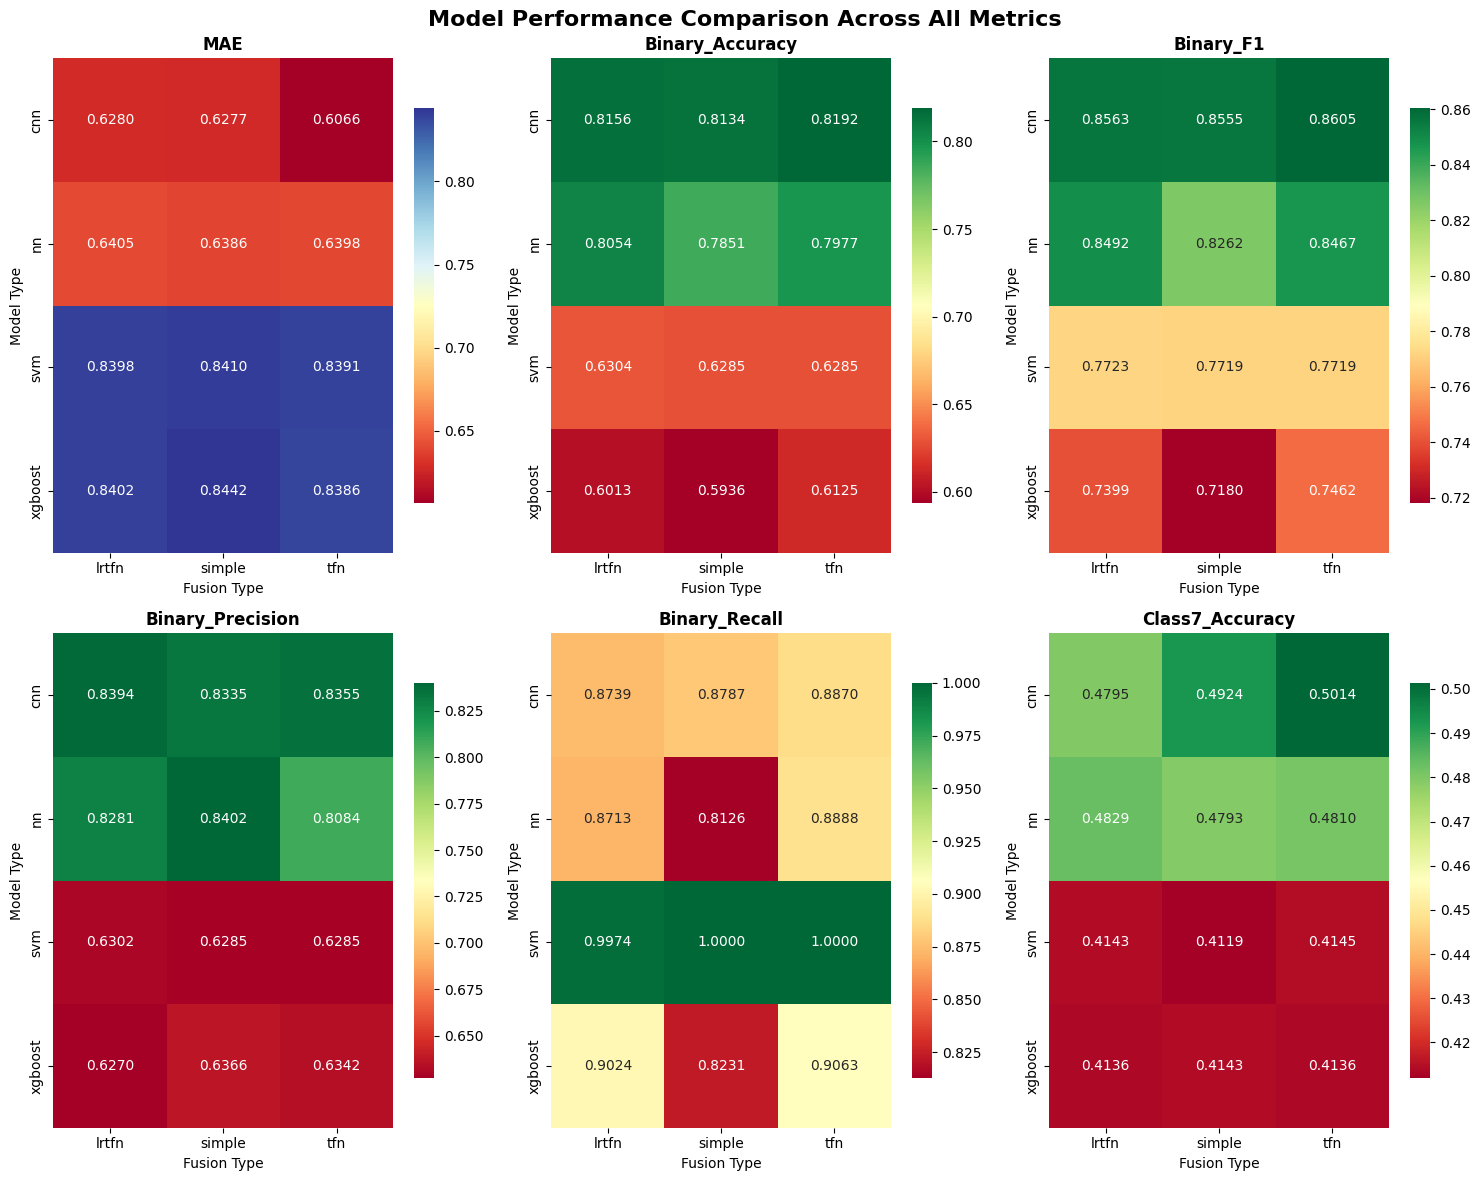

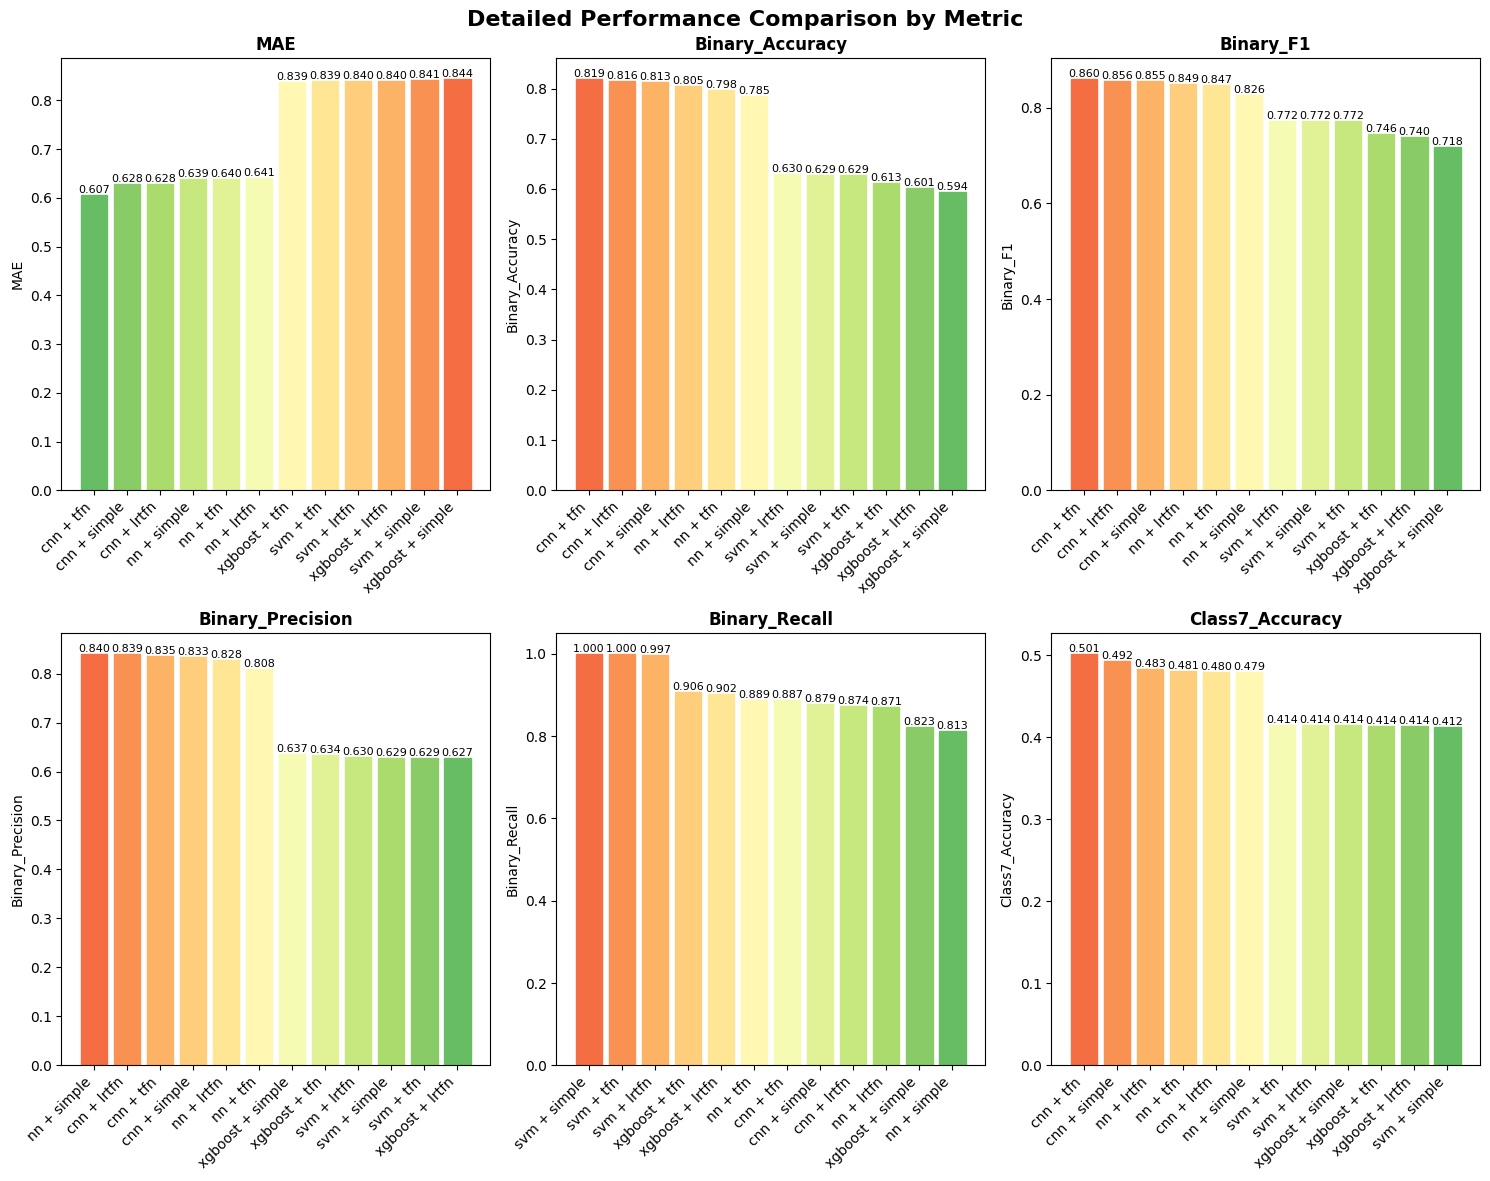

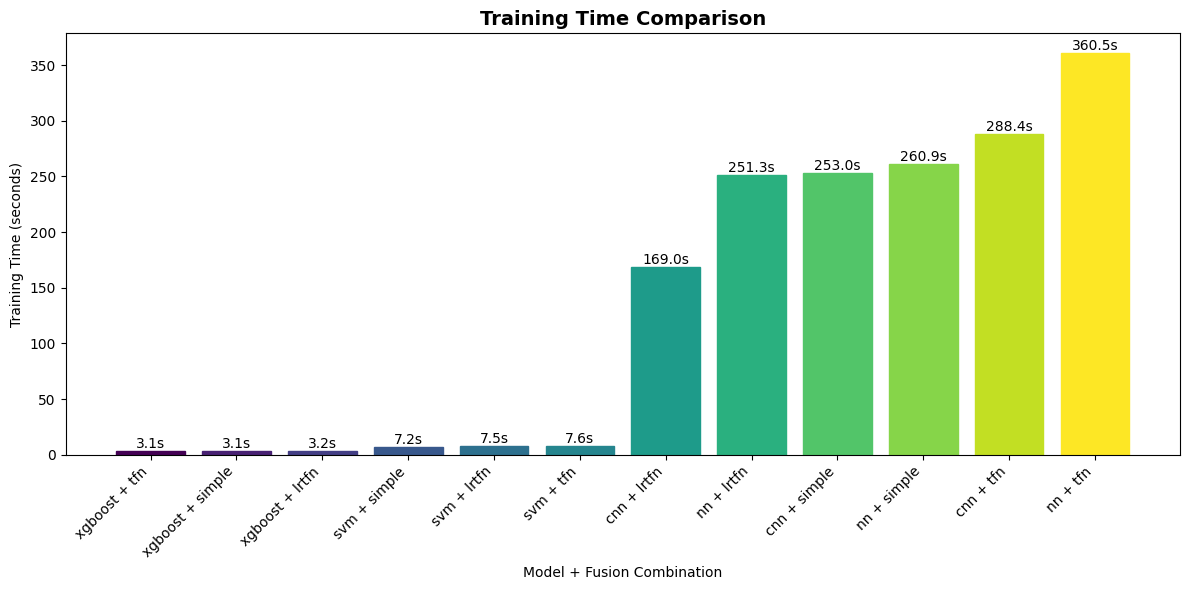


SUMMARY STATISTICS

Best Performance by Metric:
MAE: cnn + tfn (0.6066)
Binary_Accuracy: cnn + tfn (0.8192)
Binary_F1: cnn + tfn (0.8605)
Binary_Precision: nn + simple (0.8402)
Binary_Recall: svm + simple (1.0000)
Class7_Accuracy: cnn + tfn (0.5014)

Overall Ranking (weighted by multiple metrics):

Top 5 Model Combinations:
1. cnn + tfn (Score: 0.937)
2. cnn + simple (Score: 0.883)
3. cnn + lrtfn (Score: 0.872)
4. nn + lrtfn (Score: 0.834)
5. nn + tfn (Score: 0.823)

All results saved to 'model_comparison_results.csv'
Visualization files created:
- model_performance_heatmaps.png
- model_performance_bars.png
- training_time_comparison.png

Evaluation complete!


In [31]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ==========================================================================================
# CONFIGURATION
# ==========================================================================================

# Model types and fusion types to test
MODEL_TYPES = ['nn', 'cnn', 'svm', 'xgboost']
FUSION_TYPES = ['simple', 'tfn', 'lrtfn']

# General Setup
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")
print(f"--- Running on {DEVICE} ---")

# Model Hyperparameters
text_size = 300
visual_size = 35
acoustic_size = 74
input_sizes = [acoustic_size, visual_size, text_size]
hidden_sizes = (4, 16, 128)
dropouts = (0.3, 0.3, 0.3, 0.3)
post_fusion_dim = 32
output_size = 1

# Training Hyperparameters
MAX_EPOCH = 100
patience = 8
grad_clip_value = 1.0
weight_decay = 0.1

# Save directory
save_dir = './ckpt'
os.makedirs(save_dir, exist_ok=True)

# Results storage
results_df = pd.DataFrame(columns=[
    'Model_Type', 'Fusion_Type', 'MAE', 'Binary_Accuracy', 'Binary_F1', 
    'Binary_Precision', 'Binary_Recall', 'Class7_Accuracy', 'Training_Time'
])

# ==========================================================================================
# HELPER FUNCTIONS
# ==========================================================================================

def extract_features_from_loader(loader, model_wrapper_instance, desc=""):
    """Extract features from dataloader using fusion block"""
    X, y = [], []
    model_wrapper_instance.fusion_block.eval()
    with torch.no_grad():
        for batch in tqdm(loader, desc=desc):
            t, v, a, label, lengths = [item.to(DEVICE) for item in batch]
            features = model_wrapper_instance.extract_features(a, v, t, lengths)
            X.append(features)
            y.append(label.cpu().numpy())
    return np.vstack(X), np.concatenate(y)

def train_neural_network(model_wrapper, train_loader, valid_loader, model_save_path, optim_save_path):
    """Train CNN or NN model"""
    pytorch_model = model_wrapper.nn_model
    pytorch_model.to(DEVICE)
    
    optimizer = Adam([p for p in pytorch_model.parameters() if p.requires_grad], weight_decay=weight_decay)
    criterion = nn.L1Loss(reduction='sum')
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    
    best_valid_loss = float('inf')
    curr_patience = patience
    num_trials = 3
    
    for e in range(1, MAX_EPOCH + 1):
        # Training Phase
        pytorch_model.train()
        train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Train]", leave=False)
        for batch in train_iter:
            pytorch_model.zero_grad()
            t, v, a, y, l = [item.to(DEVICE) for item in batch]
            
            y_pred = pytorch_model(a, v, t, l)
            loss = criterion(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_value_([p for p in pytorch_model.parameters() if p.requires_grad], grad_clip_value)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation Phase
        pytorch_model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch in valid_loader:
                t, v, a, y, l = [item.to(DEVICE) for item in batch]
                y_pred = pytorch_model(a, v, t, l)
                loss = criterion(y_pred, y)
                valid_loss += loss.item()
        
        train_loss_avg = train_loss / len(train_loader.dataset)
        valid_loss_avg = valid_loss / len(valid_loader.dataset)
        
        # Early Stopping & Model Saving
        if valid_loss_avg < best_valid_loss:
            best_valid_loss = valid_loss_avg
            torch.save(pytorch_model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optim_save_path)
            curr_patience = patience
        else:
            curr_patience -= 1
        
        if curr_patience <= 0:
            num_trials -= 1
            curr_patience = patience
            pytorch_model.load_state_dict(torch.load(model_save_path))
            optimizer.load_state_dict(torch.load(optim_save_path))
            lr_scheduler.step()
        
        if num_trials <= 0:
            break

def evaluate_model(model_wrapper, test_loader, model_save_path=None):
    """Evaluate any model type and return metrics"""
    y_true = []
    y_pred = []
    
    if model_wrapper.model_type in ['cnn', 'nn']:
        # Load and evaluate neural network
        pytorch_model = model_wrapper.nn_model
        if model_save_path and os.path.exists(model_save_path):
            pytorch_model.load_state_dict(torch.load(model_save_path))
        
        pytorch_model.to(DEVICE)
        pytorch_model.eval()
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating Neural Network", leave=False):
                t, v, a, y, l = [item.to(DEVICE) for item in batch]
                predictions = pytorch_model(a, v, t, l)
                y_true.append(y.cpu().numpy())
                y_pred.append(predictions.cpu().numpy())
    
    elif model_wrapper.model_type in ['svm', 'xgboost']:
        # Extract features and evaluate classical model
        X_test, y_test = extract_features_from_loader(test_loader, model_wrapper, "Extracting Test Features")
        y_true = y_test
        
        if model_wrapper.model_type == 'svm':
            y_pred = model_wrapper.predict_svm(X_test)
        else:  # xgboost
            y_pred = model_wrapper.predict_xgb(X_test)
    
    # Process predictions
    if isinstance(y_true, list):
        y_true = np.concatenate(y_true, axis=0)
    if isinstance(y_pred, list):
        y_pred = np.concatenate(y_pred, axis=0)
    
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    
    # Binary classification metrics
    non_zero_mask = y_true != 0
    y_true_bin = y_true[non_zero_mask] >= 0
    y_pred_bin = y_pred[non_zero_mask] >= 0
    
    bin_acc = accuracy_score(y_true_bin, y_pred_bin)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average='binary', zero_division=0)
    
    # 7-class classification
    y_true_7class = np.clip(np.rint(y_true), -3, 3)
    y_pred_7class = np.clip(np.rint(y_pred), -3, 3)
    acc7 = accuracy_score(y_true_7class, y_pred_7class)
    
    return {
        'MAE': mae,
        'Binary_Accuracy': bin_acc,
        'Binary_F1': f1,
        'Binary_Precision': precision,
        'Binary_Recall': recall,
        'Class7_Accuracy': acc7
    }

# ==========================================================================================
# MAIN TRAINING AND EVALUATION LOOP
# ==========================================================================================

print("=== Starting Comprehensive Model Training and Evaluation ===\n")

for model_type in MODEL_TYPES:
    for fusion_type in FUSION_TYPES:
        print(f"\n{'='*60}")
        print(f"Training: {model_type.upper()} with {fusion_type.upper()} fusion")
        print(f"{'='*60}")
        
        # Initialize model
        model_wrapper = MyModel(
            model_type=model_type,
            input_sizes=input_sizes,
            hidden_sizes=hidden_sizes,
            dropouts=dropouts,
            post_fusion_dim=post_fusion_dim,
            output_size=output_size,
            fusion_type=fusion_type,
            svm_params={'kernel': 'rbf', 'C': 1.0},
            xgb_params={'n_estimators': 100, 'learning_rate': 0.1}
        )
        
        # Define save paths
        date = time.strftime('%m%d%H%M%S', time.localtime())
        model_save_path = os.path.join(save_dir, f'{date}_{model_type}_{fusion_type}_model.std')
        optim_save_path = os.path.join(save_dir, f'{date}_{model_type}_{fusion_type}_optim.std')
        
        # Training
        start_time = time.time()
        
        if model_type in ['cnn', 'nn']:
            print("Training neural network...")
            train_neural_network(model_wrapper, train_loader, valid_loader, model_save_path, optim_save_path)
            
        elif model_type in ['svm', 'xgboost']:
            print("Training classical model...")
            model_wrapper.fusion_block.to(DEVICE)
            
            # Extract features
            X_train, y_train = extract_features_from_loader(train_loader, model_wrapper, "Extracting Train Features")
            
            # Train classical model
            if model_type == 'svm':
                model_wrapper.train_svm(X_train, y_train.ravel())
            else:  # xgboost
                model_wrapper.train_xgb(X_train, y_train.ravel())
        
        training_time = time.time() - start_time
        
        # Evaluation
        print("Evaluating model...")
        metrics = evaluate_model(model_wrapper, test_loader, model_save_path if model_type in ['cnn', 'nn'] else None)
        metrics['Training_Time'] = training_time
        
        # Store results
        new_row = pd.DataFrame({
            'Model_Type': [model_type],
            'Fusion_Type': [fusion_type],
            **{k: [v] for k, v in metrics.items()}
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Print results
        print(f"\nResults for {model_type.upper()} + {fusion_type.upper()}:")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  Binary Accuracy: {metrics['Binary_Accuracy']:.4f}")
        print(f"  Binary F1: {metrics['Binary_F1']:.4f}")
        print(f"  7-Class Accuracy: {metrics['Class7_Accuracy']:.4f}")
        print(f"  Training Time: {training_time:.2f}s")

# ==========================================================================================
# RESULTS VISUALIZATION
# ==========================================================================================

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("Results saved to 'model_comparison_results.csv'")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (15, 12)

# 1. Heatmap of all metrics
fig, axes = plt.subplots(2, 3, figsize=fig_size)
fig.suptitle('Model Performance Comparison Across All Metrics', fontsize=16, fontweight='bold')

metrics_to_plot = ['MAE', 'Binary_Accuracy', 'Binary_F1', 'Binary_Precision', 'Binary_Recall', 'Class7_Accuracy']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Create pivot table for heatmap
    pivot_data = results_df.pivot(index='Model_Type', columns='Fusion_Type', values=metric)
    
    # For MAE, lower is better, so use reverse colormap
    cmap = 'RdYlBu' if metric == 'MAE' else 'RdYlGn'
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap=cmap, ax=ax, 
                cbar_kws={'shrink': 0.8})
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_xlabel('Fusion Type')
    ax.set_ylabel('Model Type')

plt.tight_layout()
plt.savefig('model_performance_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Bar plots for each metric
fig, axes = plt.subplots(2, 3, figsize=fig_size)
fig.suptitle('Detailed Performance Comparison by Metric', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Create combination labels
    results_df['Combination'] = results_df['Model_Type'] + ' + ' + results_df['Fusion_Type']
    
    # Sort by performance (ascending for MAE, descending for others)
    sorted_df = results_df.sort_values(metric, ascending=(metric == 'MAE'))
    
    bars = ax.bar(range(len(sorted_df)), sorted_df[metric])
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(sorted_df)))
    ax.set_xticklabels(sorted_df['Combination'], rotation=45, ha='right')
    
    # Color bars based on performance
    if metric == 'MAE':
        # For MAE, lower is better - color from green (best) to red (worst)
        colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(bars)))
    else:
        # For other metrics, higher is better - color from red (worst) to green (best)
        colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(bars)))
    
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('model_performance_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Training time comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
results_df['Combination'] = results_df['Model_Type'] + ' + ' + results_df['Fusion_Type']
sorted_time_df = results_df.sort_values('Training_Time')

bars = ax.bar(range(len(sorted_time_df)), sorted_time_df['Training_Time'])
ax.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Training Time (seconds)')
ax.set_xlabel('Model + Fusion Combination')
ax.set_xticks(range(len(sorted_time_df)))
ax.set_xticklabels(sorted_time_df['Combination'], rotation=45, ha='right')

# Color bars based on training time
colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Summary statistics table
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Best performance for each metric
print("\nBest Performance by Metric:")
for metric in metrics_to_plot:
    if metric == 'MAE':
        best_idx = results_df[metric].idxmin()
        print(f"{metric}: {results_df.loc[best_idx, 'Model_Type']} + {results_df.loc[best_idx, 'Fusion_Type']} "
              f"({results_df.loc[best_idx, metric]:.4f})")
    else:
        best_idx = results_df[metric].idxmax()
        print(f"{metric}: {results_df.loc[best_idx, 'Model_Type']} + {results_df.loc[best_idx, 'Fusion_Type']} "
              f"({results_df.loc[best_idx, metric]:.4f})")

# Overall ranking (you can customize the weighting)
print("\nOverall Ranking (weighted by multiple metrics):")
# Normalize metrics (0-1 scale) and compute weighted score
normalized_df = results_df.copy()
for metric in metrics_to_plot:
    if metric == 'MAE':
        # For MAE, lower is better, so invert
        normalized_df[f'{metric}_norm'] = 1 - (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())
    else:
        # For others, higher is better
        normalized_df[f'{metric}_norm'] = (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())

# Compute weighted score (you can adjust weights)
weights = {'MAE': 0.3, 'Binary_Accuracy': 0.2, 'Binary_F1': 0.2, 'Binary_Precision': 0.1, 'Binary_Recall': 0.1, 'Class7_Accuracy': 0.1}
normalized_df['Overall_Score'] = sum(normalized_df[f'{metric}_norm'] * weights[metric] for metric in weights.keys())

# Sort by overall score
ranked_df = normalized_df.sort_values('Overall_Score', ascending=False)
print("\nTop 5 Model Combinations:")
for i in range(min(5, len(ranked_df))):
    row = ranked_df.iloc[i]
    print(f"{i+1}. {row['Model_Type']} + {row['Fusion_Type']} (Score: {row['Overall_Score']:.3f})")

print(f"\nAll results saved to 'model_comparison_results.csv'")
print("Visualization files created:")
print("- model_performance_heatmaps.png")
print("- model_performance_bars.png") 
print("- training_time_comparison.png")
print("\nEvaluation complete!")

In [34]:
results_df

,Model_Type,Fusion_Type,MAE,Binary_Accuracy,Binary_F1,Binary_Precision,Binary_Recall,Class7_Accuracy,Training_Time,Combination
0,nn,simple,0.638587,0.785085,0.826174,0.840199,0.812609,0.479287,260.948817,nn + simple
1,nn,tfn,0.639813,0.797744,0.846715,0.808443,0.888792,0.481005,360.455829,nn + tfn
2,nn,lrtfn,0.640512,0.805449,0.849157,0.828132,0.871278,0.482936,251.326087,nn + lrtfn
3,cnn,simple,0.627748,0.813429,0.855499,0.833472,0.878722,0.492380,252.965952,cnn + simple
4,cnn,tfn,0.606562,0.819207,0.860480,0.835464,0.887040,0.501395,288.387897,cnn + tfn
5,cnn,lrtfn,0.628032,0.815630,0.856285,0.839361,0.873905,0.479502,169.047090,cnn + lrtfn
6,svm,simple,0.840981,0.628509,0.771882,0.628509,1.000000,0.411891,7.243567,svm + simple
7,svm,tfn,0.839077,0.628509,0.771882,0.628509,1.000000,0.414467,7.601926,svm + tfn
8,svm,lrtfn,0.839781,0.630435,0.772334,0.630152,0.997373,0.414252,7.539446,svm + lrtfn
9,xgboost,simple,0.844210,0.593561,0.717968,0.636641,0.823117,0.414252,3.132822,xgboost + simple


In [41]:
trimodal = pd.read_csv('model_comparison_results.csv')
trimodal

,Model_Type,Fusion_Type,MAE,Binary_Accuracy,Binary_F1,Binary_Precision,Binary_Recall,Class7_Accuracy,Training_Time,Combination
0,nn,simple,0.638587,0.785085,0.826174,0.840199,0.812609,0.479287,260.948817,nn + simple
1,nn,tfn,0.639813,0.797744,0.846715,0.808443,0.888792,0.481005,360.455829,nn + tfn
2,nn,lrtfn,0.640512,0.805449,0.849157,0.828132,0.871278,0.482936,251.326087,nn + lrtfn
3,cnn,simple,0.627748,0.813429,0.855499,0.833472,0.878722,0.492380,252.965952,cnn + simple
4,cnn,tfn,0.606562,0.819207,0.860480,0.835464,0.887040,0.501395,288.387897,cnn + tfn
5,cnn,lrtfn,0.628032,0.815630,0.856285,0.839361,0.873905,0.479502,169.047090,cnn + lrtfn
6,svm,simple,0.840981,0.628509,0.771882,0.628509,1.000000,0.411891,7.243567,svm + simple
7,svm,tfn,0.839077,0.628509,0.771882,0.628509,1.000000,0.414467,7.601926,svm + tfn
8,svm,lrtfn,0.839781,0.630435,0.772334,0.630152,0.997373,0.414252,7.539446,svm + lrtfn
9,xgboost,simple,0.844210,0.593561,0.717968,0.636641,0.823117,0.414252,3.132822,xgboost + simple


In [42]:
bimodal = pd.read_csv('bimodal_tfn_comparison_results.csv')
bimodal

,Modality_Combination,Model_Type,MAE,Binary_Accuracy,Binary_F1,Binary_Precision,Binary_Recall,Class7_Accuracy,Training_Time
0,audio_video,nn,0.838416,0.628509,0.771882,0.628509,1.000000,0.413608,125.334941
1,audio_video,cnn,0.803453,0.627408,0.712527,0.691674,0.734676,0.423267,189.235492
2,audio_video,svm,0.840635,0.629059,0.771835,0.629139,0.998249,0.413823,8.627165
3,audio_video,xgboost,0.841982,0.629884,0.771375,0.630453,0.993433,0.412535,3.543161
4,audio_text,nn,0.655486,0.804623,0.849640,0.822806,0.878284,0.471346,201.041164
5,audio_text,cnn,0.616693,0.808751,0.851082,0.833403,0.869527,0.494527,264.583398
6,audio_text,svm,0.826626,0.623555,0.760084,0.633996,0.948774,0.416398,8.416003
7,audio_text,xgboost,0.845782,0.598239,0.734062,0.628509,0.882224,0.411676,3.458001
8,video_text,nn,0.658553,0.799119,0.846445,0.814575,0.880911,0.469843,167.633523
9,video_text,cnn,0.606971,0.816456,0.855908,0.844776,0.867338,0.499678,209.209942


In [43]:
unimodal = pd.read_csv('unimodal_comparison_results.csv')
unimodal

,Modality_Type,Model_Type,MAE,Binary_Accuracy,Binary_F1,Binary_Precision,Binary_Recall,Class7_Accuracy,Training_Time
0,acoustic,nn,0.838414,0.628509,0.771882,0.628509,1.000000,0.413608,138.123683
1,acoustic,cnn,0.818412,0.648597,0.776240,0.647093,0.969790,0.415325,96.021747
2,acoustic,svm,0.830732,0.632636,0.773075,0.631842,0.995622,0.412964,12.985575
3,acoustic,xgboost,0.844872,0.597964,0.712005,0.647544,0.790718,0.408457,3.309297
4,visual,nn,0.838413,0.628509,0.771882,0.628509,1.000000,0.413608,176.315973
5,visual,cnn,0.803771,0.643643,0.748397,0.672721,0.843257,0.424769,127.058269
6,visual,svm,0.822533,0.618052,0.751966,0.635266,0.921191,0.413393,12.655938
7,visual,xgboost,0.843870,0.598514,0.694194,0.665862,0.725044,0.406740,3.248247
8,text,nn,0.657926,0.797193,0.837701,0.842712,0.832750,0.469199,159.577783
9,text,cnn,0.662598,0.802972,0.846878,0.827759,0.866900,0.462331,151.097275


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================================================================
# DATA LOADING AND PREPARATION
# ==========================================================================================

# Load the three datasets
trimodal = pd.read_csv('model_comparison_results.csv')
bimodal = pd.read_csv('bimodal_tfn_comparison_results.csv')
unimodal = pd.read_csv('unimodal_comparison_results.csv')

print("=== Preparing Multimodal Comparison Data ===")
print(f"Loaded trimodal data: {len(trimodal)} rows")
print(f"Loaded bimodal data: {len(bimodal)} rows")
print(f"Loaded unimodal data: {len(unimodal)} rows")

# Extract only TFN results from trimodal data
trimodal_tfn = trimodal[trimodal['Fusion_Type'] == 'tfn'].copy()
# Filter to only neural networks
trimodal_tfn = trimodal_tfn[trimodal_tfn['Model_Type'].isin(['nn', 'cnn'])].copy()
print(f"Filtered trimodal TFN neural network data: {len(trimodal_tfn)} rows")

# Prepare trimodal data
trimodal_tfn['Modality_Setup'] = 'Trimodal'
trimodal_tfn['Modality_Detail'] = 'audio+video+text'
trimodal_tfn['Combination'] = trimodal_tfn['Model_Type'] + ' (trimodal)'

# Prepare bimodal data - filter to only neural networks
bimodal_nn = bimodal[bimodal['Model_Type'].isin(['nn', 'cnn'])].copy()
bimodal_nn['Modality_Setup'] = 'Bimodal'
bimodal_nn['Modality_Detail'] = bimodal_nn['Modality_Combination']
bimodal_nn['Combination'] = bimodal_nn['Model_Type'] + ' (' + bimodal_nn['Modality_Combination'] + ')'

# Prepare unimodal data - filter to only neural networks
unimodal_nn = unimodal[unimodal['Model_Type'].isin(['nn', 'cnn'])].copy()
unimodal_nn['Modality_Setup'] = 'Unimodal'
unimodal_nn['Modality_Detail'] = unimodal_nn['Modality_Type']
unimodal_nn['Combination'] = unimodal_nn['Model_Type'] + ' (' + unimodal_nn['Modality_Type'] + ')'

print(f"Filtered bimodal neural network data: {len(bimodal_nn)} rows")
print(f"Filtered unimodal neural network data: {len(unimodal_nn)} rows")

# Combine all datasets
combined_data = pd.concat([
    trimodal_tfn[['Model_Type', 'Modality_Setup', 'Modality_Detail', 'Combination',
                  'MAE', 'Binary_Accuracy', 'Binary_F1', 'Binary_Precision', 'Binary_Recall', 
                  'Class7_Accuracy', 'Training_Time']],
    bimodal_nn[['Model_Type', 'Modality_Setup', 'Modality_Detail', 'Combination',
                'MAE', 'Binary_Accuracy', 'Binary_F1', 'Binary_Precision', 'Binary_Recall', 
                'Class7_Accuracy', 'Training_Time']],
    unimodal_nn[['Model_Type', 'Modality_Setup', 'Modality_Detail', 'Combination',
                 'MAE', 'Binary_Accuracy', 'Binary_F1', 'Binary_Precision', 'Binary_Recall', 
                 'Class7_Accuracy', 'Training_Time']]
], ignore_index=True)

print(f"Combined neural network dataset: {len(combined_data)} rows")

# Save combined data
combined_data.to_csv('multimodal_neural_comparison_results.csv', index=False)
print("Combined neural network data saved to 'multimodal_neural_comparison_results.csv'")

=== Preparing Multimodal Comparison Data ===
Loaded trimodal data: 12 rows
Loaded bimodal data: 12 rows
Loaded unimodal data: 12 rows
Filtered trimodal TFN neural network data: 2 rows
Filtered bimodal neural network data: 6 rows
Filtered unimodal neural network data: 6 rows
Combined neural network dataset: 14 rows
Combined neural network data saved to 'multimodal_neural_comparison_results.csv'


In [53]:
combined_data

,Model_Type,Modality_Setup,Modality_Detail,Combination,MAE,Binary_Accuracy,Binary_F1,Binary_Precision,Binary_Recall,Class7_Accuracy,Training_Time
0,nn,Trimodal,audio+video+text,nn (trimodal),0.639813,0.797744,0.846715,0.808443,0.888792,0.481005,360.455829
1,cnn,Trimodal,audio+video+text,cnn (trimodal),0.606562,0.819207,0.860480,0.835464,0.887040,0.501395,288.387897
2,nn,Bimodal,audio_video,nn (audio_video),0.838416,0.628509,0.771882,0.628509,1.000000,0.413608,125.334941
3,cnn,Bimodal,audio_video,cnn (audio_video),0.803453,0.627408,0.712527,0.691674,0.734676,0.423267,189.235492
4,nn,Bimodal,audio_text,nn (audio_text),0.655486,0.804623,0.849640,0.822806,0.878284,0.471346,201.041164
5,cnn,Bimodal,audio_text,cnn (audio_text),0.616693,0.808751,0.851082,0.833403,0.869527,0.494527,264.583398
6,nn,Bimodal,video_text,nn (video_text),0.658553,0.799119,0.846445,0.814575,0.880911,0.469843,167.633523
7,cnn,Bimodal,video_text,cnn (video_text),0.606971,0.816456,0.855908,0.844776,0.867338,0.499678,209.209942
8,nn,Unimodal,acoustic,nn (acoustic),0.838414,0.628509,0.771882,0.628509,1.000000,0.413608,138.123683
9,cnn,Unimodal,acoustic,cnn (acoustic),0.818412,0.648597,0.776240,0.647093,0.969790,0.415325,96.021747


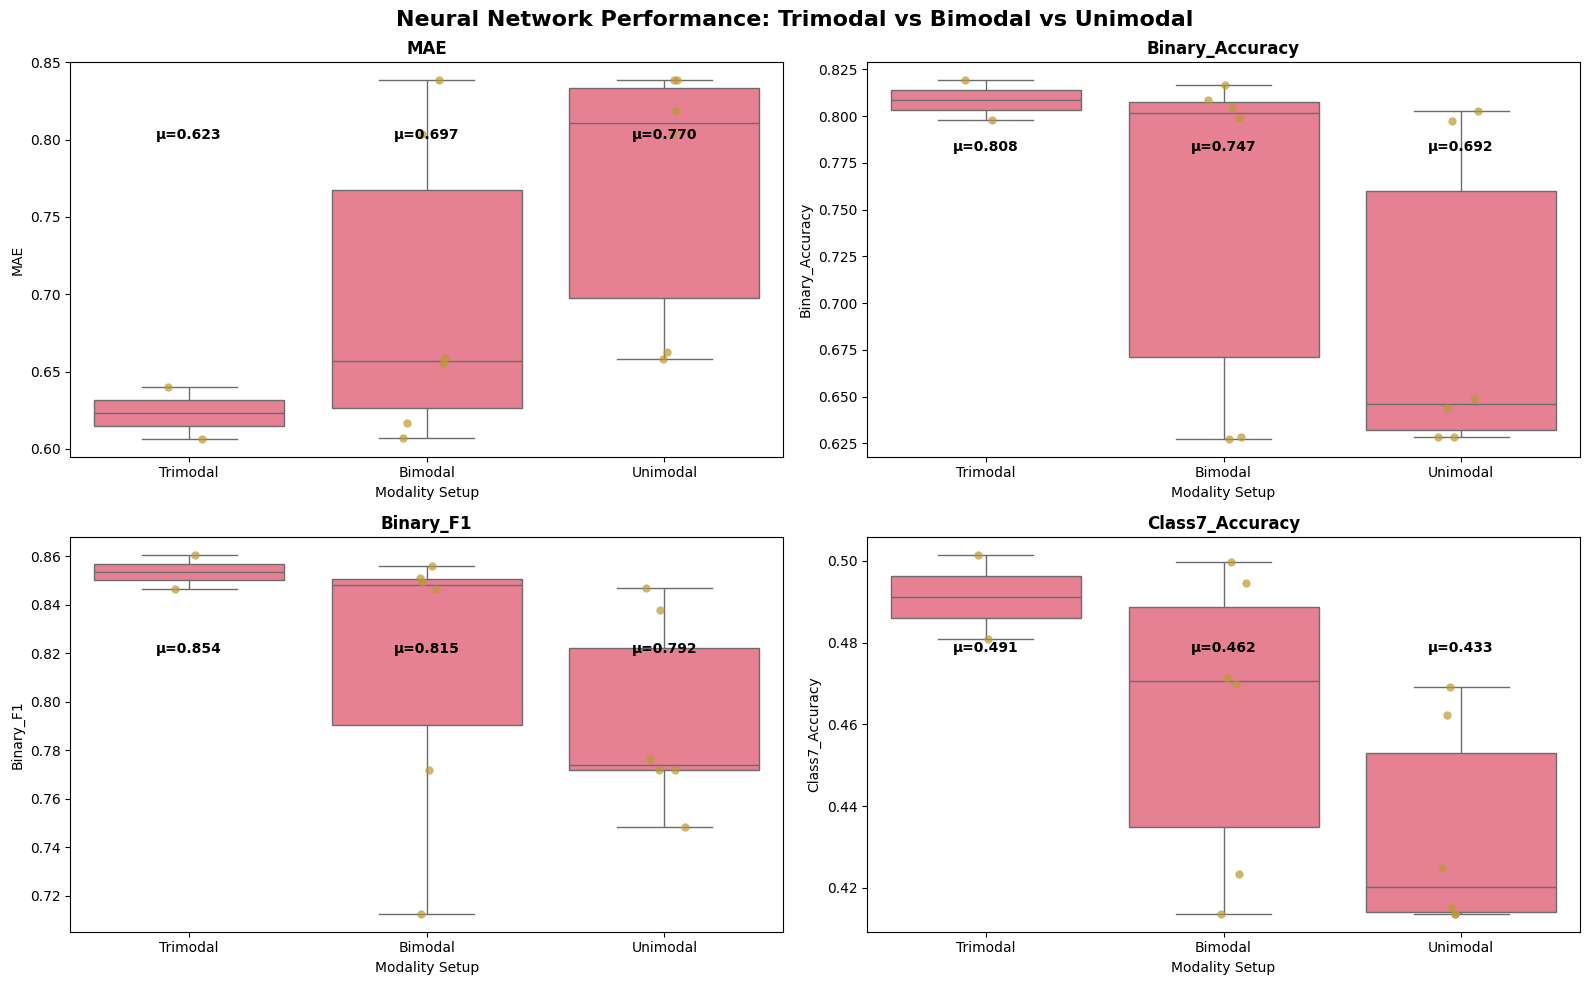

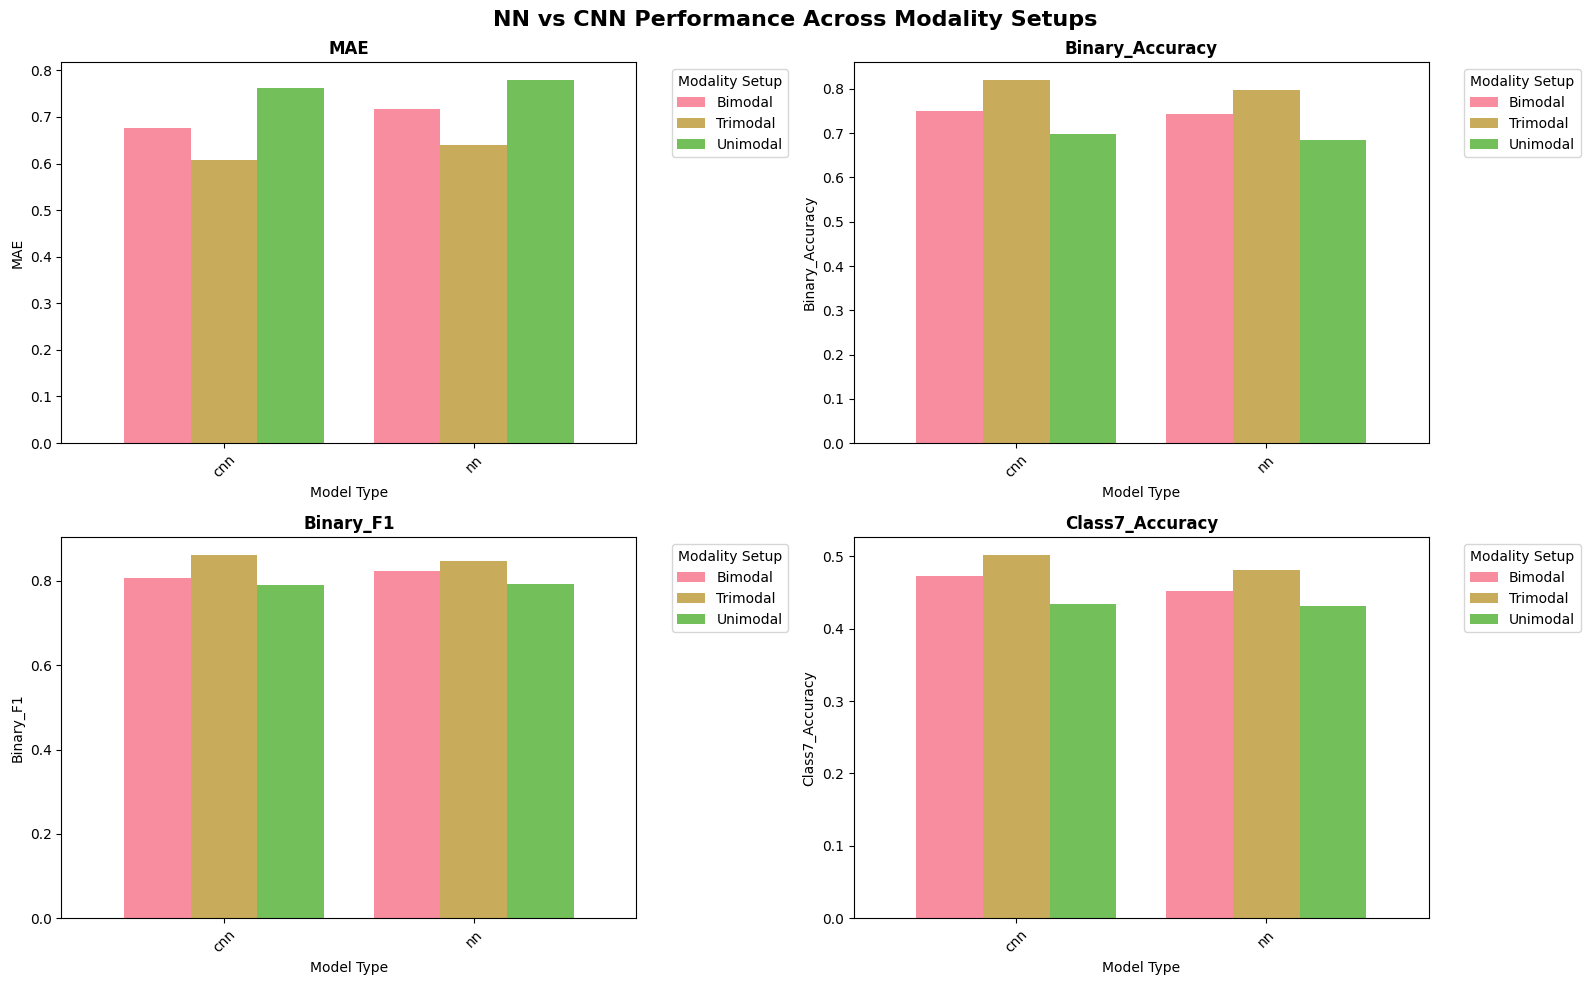

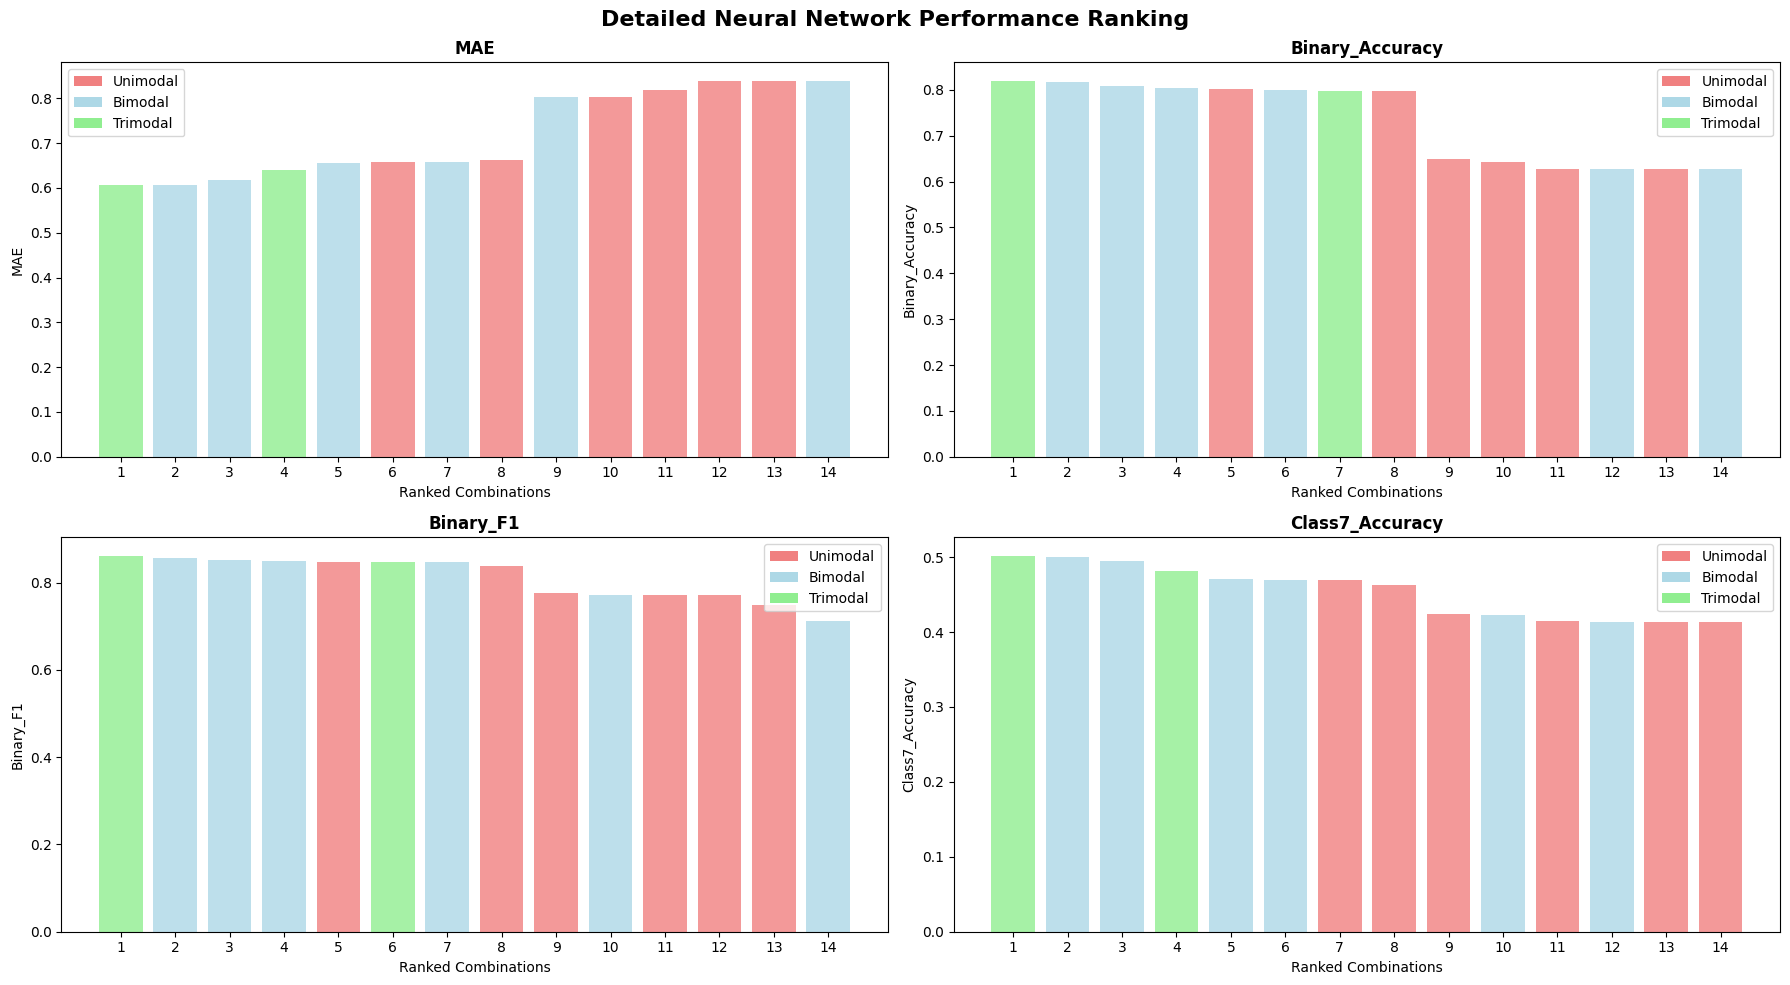

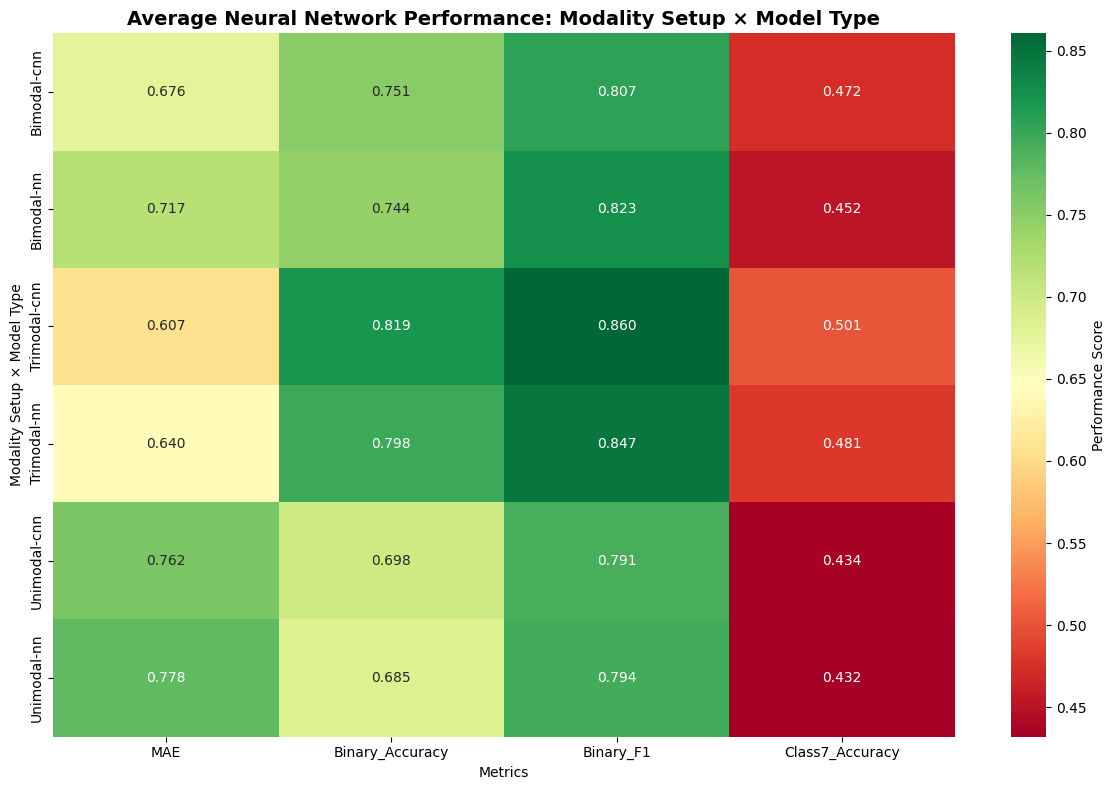

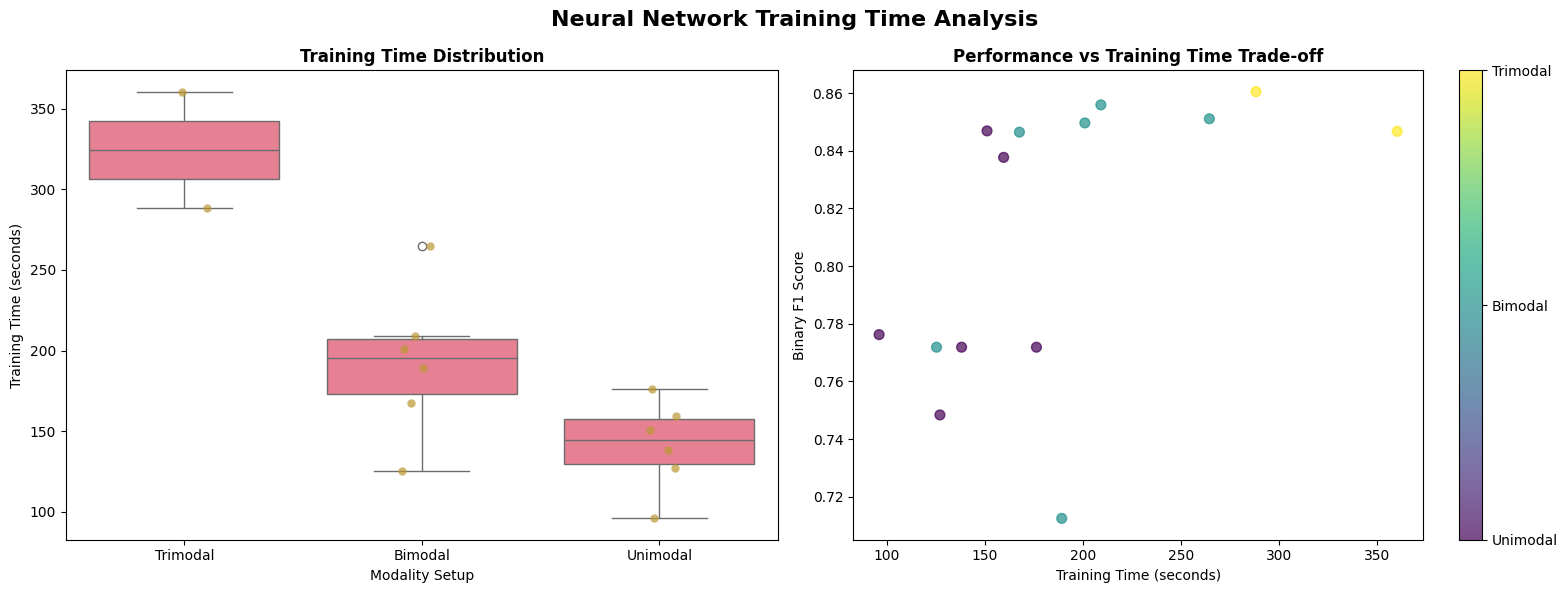


COMPREHENSIVE NEURAL NETWORK MULTIMODAL ANALYSIS

🏆 BEST PERFORMERS BY METRIC:
------------------------------------------------------------
MAE               : cnn (trimodal)                      (0.6066)
Binary_Accuracy   : cnn (trimodal)                      (0.8192)
Binary_F1         : cnn (trimodal)                      (0.8605)
Class7_Accuracy   : cnn (trimodal)                      (0.5014)

📊 PERFORMANCE BY MODALITY SETUP:
------------------------------------------------------------
                   MAE  Binary_F1  Class7_Accuracy
Modality_Setup                                    
Bimodal         0.6966     0.8146           0.4620
Trimodal        0.6232     0.8536           0.4912
Unimodal        0.7699     0.7922           0.4331

🏗️ PERFORMANCE BY NEURAL NETWORK TYPE:
------------------------------------------------------------
               MAE  Binary_F1  Class7_Accuracy
Model_Type                                    
cnn         0.7026     0.8074           0.4602
nn     

In [55]:
# ==========================================================================================
# VISUALIZATION SETUP
# ==========================================================================================

plt.style.use('default')
sns.set_palette("husl")
metrics_to_plot = ['MAE', 'Binary_Accuracy', 'Binary_F1', 'Class7_Accuracy']

# ==========================================================================================
# 1. PERFORMANCE COMPARISON BY METRIC (4 subplots)
# ==========================================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Neural Network Performance: Trimodal vs Bimodal vs Unimodal', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Create box plot showing distribution across modality setups
    box_plot = sns.boxplot(data=combined_data, x='Modality_Setup', y=metric, ax=ax)
    
    # Make box plot transparent
    for patch in box_plot.artists:
        patch.set_alpha(0.8)
    
    # Add individual points
    sns.stripplot(data=combined_data, x='Modality_Setup', y=metric, ax=ax, 
                  size=6, alpha=0.7, jitter=True)
    
    ax.set_title(f'{metric}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Modality Setup')
    ax.set_ylabel(metric)
    
    # Add mean values as text
    for i, setup in enumerate(['Trimodal', 'Bimodal', 'Unimodal']):
        if setup in combined_data['Modality_Setup'].values:
            mean_val = combined_data[combined_data['Modality_Setup'] == setup][metric].mean()
            ax.text(i, ax.get_ylim()[1] * 0.95, f'μ={mean_val:.3f}', 
                   ha='center', va='top', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('multimodal_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================================================
# 2. MODEL TYPE PERFORMANCE ACROSS MODALITY SETUPS
# ==========================================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('NN vs CNN Performance Across Modality Setups', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Create grouped bar plot
    pivot_data = combined_data.pivot_table(index='Model_Type', columns='Modality_Setup', 
                                          values=metric, aggfunc='mean')
    
    pivot_data.plot(kind='bar', ax=ax, alpha=0.8, width=0.8)
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('Model Type')
    ax.legend(title='Modality Setup', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('multimodal_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================================================
# 3. DETAILED RANKING COMPARISON
# ==========================================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Detailed Neural Network Performance Ranking', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by performance
    sorted_data = combined_data.sort_values(metric, ascending=(metric == 'MAE'))
    
    # Create color map based on modality setup
    color_map = {'Unimodal': 'lightcoral', 'Bimodal': 'lightblue', 'Trimodal': 'lightgreen'}
    colors = [color_map[setup] for setup in sorted_data['Modality_Setup']]
    
    bars = ax.bar(range(len(sorted_data)), sorted_data[metric], color=colors, alpha=0.8)
    
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('Ranked Combinations')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[setup], label=setup) 
                      for setup in ['Unimodal', 'Bimodal', 'Trimodal']]
    ax.legend(handles=legend_elements, loc='upper right' if metric != 'MAE' else 'upper left')
    
    # Show only every 5th label to avoid crowding
    step = max(1, len(sorted_data) // 10)
    ax.set_xticks(range(0, len(sorted_data), step))
    ax.set_xticklabels([f"{i+1}" for i in range(0, len(sorted_data), step)])

plt.tight_layout()
plt.savefig('multimodal_detailed_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================================================
# 4. SUMMARY HEATMAP
# ==========================================================================================

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create summary statistics
summary_stats = combined_data.groupby(['Modality_Setup', 'Model_Type'])[metrics_to_plot].mean()

# Create heatmap
sns.heatmap(summary_stats, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax,
            cbar_kws={'label': 'Performance Score'})
ax.set_title('Average Neural Network Performance: Modality Setup × Model Type', 
             fontweight='bold', fontsize=14)
ax.set_xlabel('Metrics')
ax.set_ylabel('Modality Setup × Model Type')

plt.tight_layout()
plt.savefig('multimodal_summary_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================================================
# 5. TRAINING TIME ANALYSIS
# ==========================================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Neural Network Training Time Analysis', fontsize=16, fontweight='bold')

# Training time by modality setup
ax1 = axes[0]
box_plot1 = sns.boxplot(data=combined_data, x='Modality_Setup', y='Training_Time', ax=ax1)

# Make box plot transparent
for patch in box_plot1.artists:
    patch.set_alpha(0.8)

sns.stripplot(data=combined_data, x='Modality_Setup', y='Training_Time', ax=ax1, 
              size=6, alpha=0.7, jitter=True)
ax1.set_title('Training Time Distribution', fontweight='bold')
ax1.set_ylabel('Training Time (seconds)')
ax1.set_xlabel('Modality Setup')

# Performance vs Training Time scatter
ax2 = axes[1]
scatter = ax2.scatter(combined_data['Training_Time'], combined_data['Binary_F1'], 
                     c=[{'Unimodal': 0, 'Bimodal': 1, 'Trimodal': 2}[setup] 
                        for setup in combined_data['Modality_Setup']], 
                     cmap='viridis', alpha=0.7, s=50)

ax2.set_xlabel('Training Time (seconds)')
ax2.set_ylabel('Binary F1 Score')
ax2.set_title('Performance vs Training Time Trade-off', fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Unimodal', 'Bimodal', 'Trimodal'])

plt.tight_layout()
plt.savefig('multimodal_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================================================
# STATISTICAL ANALYSIS AND SUMMARY
# ==========================================================================================

print("\n" + "="*80)
print("COMPREHENSIVE NEURAL NETWORK MULTIMODAL ANALYSIS")
print("="*80)

# Best performers for each metric
print("\n🏆 BEST PERFORMERS BY METRIC:")
print("-" * 60)
for metric in metrics_to_plot:
    if metric == 'MAE':
        best_idx = combined_data[metric].idxmin()
        print(f"{metric:18}: {combined_data.loc[best_idx, 'Combination']:35} ({combined_data.loc[best_idx, metric]:.4f})")
    else:
        best_idx = combined_data[metric].idxmax()
        print(f"{metric:18}: {combined_data.loc[best_idx, 'Combination']:35} ({combined_data.loc[best_idx, metric]:.4f})")

# Performance by modality setup
print(f"\n📊 PERFORMANCE BY MODALITY SETUP:")
print("-" * 60)
modality_avg = combined_data.groupby('Modality_Setup')[['MAE', 'Binary_F1', 'Class7_Accuracy']].mean()
print(modality_avg.round(4))

# Performance by model type
print(f"\n🏗️ PERFORMANCE BY NEURAL NETWORK TYPE:")
print("-" * 60)
model_avg = combined_data.groupby('Model_Type')[['MAE', 'Binary_F1', 'Class7_Accuracy']].mean()
print(model_avg.round(4))

# Training time analysis
print(f"\n⚡ TRAINING TIME ANALYSIS:")
print("-" * 60)
time_avg = combined_data.groupby('Modality_Setup')['Training_Time'].agg(['mean', 'std']).round(2)
print("Average training time by modality setup:")
print(time_avg)

# Top performers overall
print(f"\n🎯 TOP 10 OVERALL PERFORMERS (by Binary F1):")
print("-" * 60)
top_performers = combined_data.nlargest(10, 'Binary_F1')[['Combination', 'Binary_F1', 'MAE', 'Training_Time']]
for i, (_, row) in enumerate(top_performers.iterrows(), 1):
    print(f"{i:2d}. {row['Combination']:35} F1:{row['Binary_F1']:.4f} MAE:{row['MAE']:.4f} Time:{row['Training_Time']:6.1f}s")

# Statistical significance tests
print(f"\n📈 STATISTICAL INSIGHTS:")
print("-" * 60)

# Compare modality setups
f1_scores = {
    'Unimodal': combined_data[combined_data['Modality_Setup'] == 'Unimodal']['Binary_F1'].values,
    'Bimodal': combined_data[combined_data['Modality_Setup'] == 'Bimodal']['Binary_F1'].values,
    'Trimodal': combined_data[combined_data['Modality_Setup'] == 'Trimodal']['Binary_F1'].values
}

for setup, scores in f1_scores.items():
    print(f"{setup:10}: F1 = {scores.mean():.4f} ± {scores.std():.4f} (n={len(scores)})")

# Best configuration analysis
print(f"\n💡 KEY FINDINGS:")
print("-" * 60)

# Find best in each category
best_unimodal = combined_data[combined_data['Modality_Setup'] == 'Unimodal'].nlargest(1, 'Binary_F1').iloc[0]
best_bimodal = combined_data[combined_data['Modality_Setup'] == 'Bimodal'].nlargest(1, 'Binary_F1').iloc[0]
best_trimodal = combined_data[combined_data['Modality_Setup'] == 'Trimodal'].nlargest(1, 'Binary_F1').iloc[0]

print(f"1. Best Unimodal:  {best_unimodal['Combination']:30} (F1: {best_unimodal['Binary_F1']:.4f})")
print(f"2. Best Bimodal:   {best_bimodal['Combination']:30} (F1: {best_bimodal['Binary_F1']:.4f})")
print(f"3. Best Trimodal:  {best_trimodal['Combination']:30} (F1: {best_trimodal['Binary_F1']:.4f})")

# Performance gain analysis
unimodal_max = combined_data[combined_data['Modality_Setup'] == 'Unimodal']['Binary_F1'].max()
bimodal_max = combined_data[combined_data['Modality_Setup'] == 'Bimodal']['Binary_F1'].max()
trimodal_max = combined_data[combined_data['Modality_Setup'] == 'Trimodal']['Binary_F1'].max()

print(f"\n4. Performance Gains:")
print(f"   Unimodal → Bimodal:  {((bimodal_max / unimodal_max - 1) * 100):+.2f}%")
print(f"   Bimodal → Trimodal:  {((trimodal_max / bimodal_max - 1) * 100):+.2f}%")
print(f"   Unimodal → Trimodal: {((trimodal_max / unimodal_max - 1) * 100):+.2f}%")

# Efficiency analysis
efficiency_data = combined_data.copy()
efficiency_data['Efficiency'] = efficiency_data['Binary_F1'] / (efficiency_data['Training_Time'] / 60)  # F1 per minute
best_efficiency = efficiency_data.nlargest(1, 'Efficiency').iloc[0]
print(f"\n5. Most Efficient: {best_efficiency['Combination']:30} ({best_efficiency['Efficiency']:.4f} F1/min)")

print(f"\n📁 FILES GENERATED:")
print("-" * 60)
print("• multimodal_neural_comparison_results.csv - Combined neural network dataset")
print("• multimodal_performance_comparison.png - Neural network performance distributions")
print("• multimodal_model_comparison.png - NN vs CNN analysis")
print("• multimodal_detailed_ranking.png - Detailed neural network rankings")
print("• multimodal_summary_heatmap.png - Neural network performance matrix")
print("• multimodal_training_analysis.png - Neural network training time analysis")

print(f"\n✅ NEURAL NETWORK MULTIMODAL COMPARISON COMPLETE!")
print("="*80)